In [24]:
# base environment
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn
import torch.nn.functional as F
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
from tqdm.auto import trange, tqdm


from sklearn import model_selection
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score,roc_auc_score,f1_score

In [4]:
#df = pd.read_excel(r"D:\HKUST\Program\结肠癌分类器\终稿\Ver 10.24\combined_data_new.xlsx",index_col=0)
# df = pd.read_excel('merged.xlsx',index_col=0) 

df = pd.read_excel(r"D:\HKUST\Program\结肠癌分类器\终稿\去粪指标修改\Eng_standard.xlsx")

In [5]:
#pd.set_option('display.max_rows', None) # 展示所有行
pd.set_option('display.max_columns', None)

In [6]:
#df.drop(["Unnamed: 0.1","Unnamed: 0.1.1",'Unnamed: 0.1.1.1','癌前病变', '良性疾病', '健康或非结肠疾病'],axis=1,inplace=True)
df

,Age,WBC,Lym,Mon,Ne,Eos,Baso,Lym%,Mon%,Eos%,Baso%,Ne%,RBC,Hb,HCT,MCV,MCH,MCHC,RDW,PLT,MPV,PCT,PDW,P-LCR,Urea,Na+,K+,Cl-,Glu,Creatinine,CO₂CP,Uric Acid,CA19-9,TBIL,DBIL,TP,ALB,Globulin,A/G,ALT,AST,ALP,TBA,γ-GT,Prealbumin,LDH,IBIL,CEA,FIT positive,FIT's data is missing',Fecal transferrin positive,Fecal transferrin's data is missing',Gender,BMI,癌
0,61,4.16,1.09,0.52,2.53,0.00,0.02,26.2,12.5,0.0,0.5,60.8,5.08,173.0,48.4,95.3,34.1,357.0,13.6,99.0,9.5,0.09,10.7,21.9,4.1,141.0,4.5,101.0,5.6,86.0,27.0,0.36,22.504914,5.3,2.4,69.0,39.0,30.0,1.30,44.0,41.0,80.0,5.1,51.0,147.00000,249.0,2.9,8.699406,0,1,0,1,1.00000,22.222222,0
1,73,3.63,0.75,0.17,2.67,0.04,0.00,20.7,4.7,1.1,0.0,73.5,4.81,149.0,43.5,90.4,31.0,343.0,12.9,101.0,10.4,0.11,12.4,28.0,4.0,142.0,4.0,106.0,4.0,56.0,26.0,0.26,22.504914,19.4,6.9,72.0,47.0,25.0,1.88,16.0,22.0,68.0,6.5,38.0,192.00000,152.0,12.5,8.699406,0,1,0,1,1.00000,25.826446,0
2,84,3.65,1.33,0.22,1.98,0.10,0.02,36.4,6.0,2.7,0.5,54.4,3.68,122.0,35.2,95.7,33.2,347.0,12.8,167.0,9.2,0.15,9.5,17.6,3.9,136.0,4.2,97.0,6.3,80.0,25.0,0.21,27.910000,5.3,1.6,70.0,43.0,27.0,1.59,6.0,17.0,109.0,2.2,26.0,210.00000,126.0,3.7,1.690000,0,1,0,1,0.00000,19.531250,0
3,71,7.29,1.79,0.30,5.08,0.12,0.00,24.6,4.1,1.6,0.0,69.7,3.84,125.0,37.2,96.9,32.6,336.0,12.4,187.0,9.6,0.18,10.4,21.6,8.3,146.0,4.1,105.0,5.6,85.0,26.0,0.27,22.504914,7.3,2.2,74.0,45.0,29.0,1.55,14.0,16.0,38.0,10.1,11.0,225.49881,146.0,5.1,8.699406,0,1,0,1,0.63176,23.857203,0
4,80,5.68,1.81,0.37,3.36,0.12,0.02,31.9,6.5,2.1,0.4,59.1,3.06,99.0,27.9,91.2,32.4,355.0,11.6,175.0,9.2,0.16,9.1,17.7,4.9,132.0,3.8,100.0,9.7,66.0,26.0,0.38,22.504914,7.7,2.3,63.0,37.0,26.0,1.42,11.0,18.0,66.0,2.3,18.0,199.00000,143.0,5.4,3.630000,0,1,0,1,0.00000,29.968783,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27906,56,5.51,1.82,0.45,3.04,0.17,0.03,33.0,8.2,3.1,0.5,55.2,4.24,132.0,39.1,92.2,31.1,338.0,12.0,203.0,10.5,0.21,11.9,28.6,7.7,143.0,4.1,110.0,5.2,98.0,23.0,0.53,22.504914,13.2,3.9,62.0,37.0,25.0,1.48,22.0,13.0,106.0,2.8,82.0,257.00000,139.0,9.3,8.699406,0,1,0,1,1.00000,28.081633,0
27907,76,5.71,1.81,0.35,3.48,0.03,0.04,31.7,6.1,0.5,0.7,61.0,3.93,115.0,36.0,91.6,29.3,319.0,12.0,229.0,10.2,0.23,10.8,25.5,4.3,143.0,4.3,108.0,4.1,79.0,23.0,0.34,22.504914,6.0,2.1,62.0,36.0,26.0,1.38,11.0,18.0,97.0,2.3,23.0,228.00000,151.0,3.9,8.699406,0,1,0,1,0.00000,26.175195,0
27908,65,5.99,1.79,0.73,2.92,0.48,0.07,29.9,12.2,8.0,1.2,48.7,4.21,126.0,38.5,91.4,29.9,327.0,13.0,206.0,13.1,0.27,19.0,50.4,6.1,142.0,3.9,109.0,4.0,78.0,23.0,0.36,22.504914,10.9,3.3,63.0,40.0,23.0,1.74,11.0,14.0,78.0,2.2,14.0,213.00000,195.0,7.6,1.280000,0,1,0,1,1.00000,18.591130,0
27909,52,6.72,2.11,0.49,3.86,0.21,0.05,31.4,7.3,3.1,0.7,57.5,4.33,132.0,39.0,90.1,30.5,338.0,12.6,326.0,10.3,0.34,11.7,27.3,4.1,139.0,4.1,102.0,4.9,62.0,29.0,0.35,7.480000,8.7,1.2,80.0,49.0,31.0,1.58,22.0,30.0,100.0,20.1,52.0,310.00000,183.0,7.5,0.750000,0,0,0,0,0.00000,24.243918,0


In [7]:
df=df.head(27911)
df

,Age,WBC,Lym,Mon,Ne,Eos,Baso,Lym%,Mon%,Eos%,Baso%,Ne%,RBC,Hb,HCT,MCV,MCH,MCHC,RDW,PLT,MPV,PCT,PDW,P-LCR,Urea,Na+,K+,Cl-,Glu,Creatinine,CO₂CP,Uric Acid,CA19-9,TBIL,DBIL,TP,ALB,Globulin,A/G,ALT,AST,ALP,TBA,γ-GT,Prealbumin,LDH,IBIL,CEA,FIT positive,FIT's data is missing',Fecal transferrin positive,Fecal transferrin's data is missing',Gender,BMI,癌
0,61,4.16,1.09,0.52,2.53,0.00,0.02,26.2,12.5,0.0,0.5,60.8,5.08,173.0,48.4,95.3,34.1,357.0,13.6,99.0,9.5,0.09,10.7,21.9,4.1,141.0,4.5,101.0,5.6,86.0,27.0,0.36,22.504914,5.3,2.4,69.0,39.0,30.0,1.30,44.0,41.0,80.0,5.1,51.0,147.00000,249.0,2.9,8.699406,0,1,0,1,1.00000,22.222222,0
1,73,3.63,0.75,0.17,2.67,0.04,0.00,20.7,4.7,1.1,0.0,73.5,4.81,149.0,43.5,90.4,31.0,343.0,12.9,101.0,10.4,0.11,12.4,28.0,4.0,142.0,4.0,106.0,4.0,56.0,26.0,0.26,22.504914,19.4,6.9,72.0,47.0,25.0,1.88,16.0,22.0,68.0,6.5,38.0,192.00000,152.0,12.5,8.699406,0,1,0,1,1.00000,25.826446,0
2,84,3.65,1.33,0.22,1.98,0.10,0.02,36.4,6.0,2.7,0.5,54.4,3.68,122.0,35.2,95.7,33.2,347.0,12.8,167.0,9.2,0.15,9.5,17.6,3.9,136.0,4.2,97.0,6.3,80.0,25.0,0.21,27.910000,5.3,1.6,70.0,43.0,27.0,1.59,6.0,17.0,109.0,2.2,26.0,210.00000,126.0,3.7,1.690000,0,1,0,1,0.00000,19.531250,0
3,71,7.29,1.79,0.30,5.08,0.12,0.00,24.6,4.1,1.6,0.0,69.7,3.84,125.0,37.2,96.9,32.6,336.0,12.4,187.0,9.6,0.18,10.4,21.6,8.3,146.0,4.1,105.0,5.6,85.0,26.0,0.27,22.504914,7.3,2.2,74.0,45.0,29.0,1.55,14.0,16.0,38.0,10.1,11.0,225.49881,146.0,5.1,8.699406,0,1,0,1,0.63176,23.857203,0
4,80,5.68,1.81,0.37,3.36,0.12,0.02,31.9,6.5,2.1,0.4,59.1,3.06,99.0,27.9,91.2,32.4,355.0,11.6,175.0,9.2,0.16,9.1,17.7,4.9,132.0,3.8,100.0,9.7,66.0,26.0,0.38,22.504914,7.7,2.3,63.0,37.0,26.0,1.42,11.0,18.0,66.0,2.3,18.0,199.00000,143.0,5.4,3.630000,0,1,0,1,0.00000,29.968783,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27906,56,5.51,1.82,0.45,3.04,0.17,0.03,33.0,8.2,3.1,0.5,55.2,4.24,132.0,39.1,92.2,31.1,338.0,12.0,203.0,10.5,0.21,11.9,28.6,7.7,143.0,4.1,110.0,5.2,98.0,23.0,0.53,22.504914,13.2,3.9,62.0,37.0,25.0,1.48,22.0,13.0,106.0,2.8,82.0,257.00000,139.0,9.3,8.699406,0,1,0,1,1.00000,28.081633,0
27907,76,5.71,1.81,0.35,3.48,0.03,0.04,31.7,6.1,0.5,0.7,61.0,3.93,115.0,36.0,91.6,29.3,319.0,12.0,229.0,10.2,0.23,10.8,25.5,4.3,143.0,4.3,108.0,4.1,79.0,23.0,0.34,22.504914,6.0,2.1,62.0,36.0,26.0,1.38,11.0,18.0,97.0,2.3,23.0,228.00000,151.0,3.9,8.699406,0,1,0,1,0.00000,26.175195,0
27908,65,5.99,1.79,0.73,2.92,0.48,0.07,29.9,12.2,8.0,1.2,48.7,4.21,126.0,38.5,91.4,29.9,327.0,13.0,206.0,13.1,0.27,19.0,50.4,6.1,142.0,3.9,109.0,4.0,78.0,23.0,0.36,22.504914,10.9,3.3,63.0,40.0,23.0,1.74,11.0,14.0,78.0,2.2,14.0,213.00000,195.0,7.6,1.280000,0,1,0,1,1.00000,18.591130,0
27909,52,6.72,2.11,0.49,3.86,0.21,0.05,31.4,7.3,3.1,0.7,57.5,4.33,132.0,39.0,90.1,30.5,338.0,12.6,326.0,10.3,0.34,11.7,27.3,4.1,139.0,4.1,102.0,4.9,62.0,29.0,0.35,7.480000,8.7,1.2,80.0,49.0,31.0,1.58,22.0,30.0,100.0,20.1,52.0,310.00000,183.0,7.5,0.750000,0,0,0,0,0.00000,24.243918,0


In [8]:
translation=pd.read_excel(r"D:\HKUST\Program\结肠癌分类器\终稿\Ver 10.24\feature_name 英文.xlsx")
translation

for i in translation.index:
    chn=translation["chinese"].loc[i]
    eng=translation["English"].loc[i]
    df.rename(columns={chn: eng}, inplace=True)
    df.rename(columns={chn+"异常": eng+" positive"}, inplace=True)
    df.rename(columns={chn+"数据缺失": eng+"'s data is missing'"}, inplace=True)

In [9]:
df

,Age,WBC,Lym,Mon,Ne,Eos,Baso,Lym%,Mon%,Eos%,Baso%,Ne%,RBC,Hb,HCT,MCV,MCH,MCHC,RDW,PLT,MPV,PCT,PDW,P-LCR,Urea,Na+,K+,Cl-,Glu,Creatinine,CO₂CP,Uric Acid,CA19-9,TBIL,DBIL,TP,ALB,Globulin,A/G,ALT,AST,ALP,TBA,γ-GT,Prealbumin,LDH,IBIL,CEA,FIT positive,FIT's data is missing',Fecal transferrin positive,Fecal transferrin's data is missing',Gender,BMI,癌
0,61,4.16,1.09,0.52,2.53,0.00,0.02,26.2,12.5,0.0,0.5,60.8,5.08,173.0,48.4,95.3,34.1,357.0,13.6,99.0,9.5,0.09,10.7,21.9,4.1,141.0,4.5,101.0,5.6,86.0,27.0,0.36,22.504914,5.3,2.4,69.0,39.0,30.0,1.30,44.0,41.0,80.0,5.1,51.0,147.00000,249.0,2.9,8.699406,0,1,0,1,1.00000,22.222222,0
1,73,3.63,0.75,0.17,2.67,0.04,0.00,20.7,4.7,1.1,0.0,73.5,4.81,149.0,43.5,90.4,31.0,343.0,12.9,101.0,10.4,0.11,12.4,28.0,4.0,142.0,4.0,106.0,4.0,56.0,26.0,0.26,22.504914,19.4,6.9,72.0,47.0,25.0,1.88,16.0,22.0,68.0,6.5,38.0,192.00000,152.0,12.5,8.699406,0,1,0,1,1.00000,25.826446,0
2,84,3.65,1.33,0.22,1.98,0.10,0.02,36.4,6.0,2.7,0.5,54.4,3.68,122.0,35.2,95.7,33.2,347.0,12.8,167.0,9.2,0.15,9.5,17.6,3.9,136.0,4.2,97.0,6.3,80.0,25.0,0.21,27.910000,5.3,1.6,70.0,43.0,27.0,1.59,6.0,17.0,109.0,2.2,26.0,210.00000,126.0,3.7,1.690000,0,1,0,1,0.00000,19.531250,0
3,71,7.29,1.79,0.30,5.08,0.12,0.00,24.6,4.1,1.6,0.0,69.7,3.84,125.0,37.2,96.9,32.6,336.0,12.4,187.0,9.6,0.18,10.4,21.6,8.3,146.0,4.1,105.0,5.6,85.0,26.0,0.27,22.504914,7.3,2.2,74.0,45.0,29.0,1.55,14.0,16.0,38.0,10.1,11.0,225.49881,146.0,5.1,8.699406,0,1,0,1,0.63176,23.857203,0
4,80,5.68,1.81,0.37,3.36,0.12,0.02,31.9,6.5,2.1,0.4,59.1,3.06,99.0,27.9,91.2,32.4,355.0,11.6,175.0,9.2,0.16,9.1,17.7,4.9,132.0,3.8,100.0,9.7,66.0,26.0,0.38,22.504914,7.7,2.3,63.0,37.0,26.0,1.42,11.0,18.0,66.0,2.3,18.0,199.00000,143.0,5.4,3.630000,0,1,0,1,0.00000,29.968783,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27906,56,5.51,1.82,0.45,3.04,0.17,0.03,33.0,8.2,3.1,0.5,55.2,4.24,132.0,39.1,92.2,31.1,338.0,12.0,203.0,10.5,0.21,11.9,28.6,7.7,143.0,4.1,110.0,5.2,98.0,23.0,0.53,22.504914,13.2,3.9,62.0,37.0,25.0,1.48,22.0,13.0,106.0,2.8,82.0,257.00000,139.0,9.3,8.699406,0,1,0,1,1.00000,28.081633,0
27907,76,5.71,1.81,0.35,3.48,0.03,0.04,31.7,6.1,0.5,0.7,61.0,3.93,115.0,36.0,91.6,29.3,319.0,12.0,229.0,10.2,0.23,10.8,25.5,4.3,143.0,4.3,108.0,4.1,79.0,23.0,0.34,22.504914,6.0,2.1,62.0,36.0,26.0,1.38,11.0,18.0,97.0,2.3,23.0,228.00000,151.0,3.9,8.699406,0,1,0,1,0.00000,26.175195,0
27908,65,5.99,1.79,0.73,2.92,0.48,0.07,29.9,12.2,8.0,1.2,48.7,4.21,126.0,38.5,91.4,29.9,327.0,13.0,206.0,13.1,0.27,19.0,50.4,6.1,142.0,3.9,109.0,4.0,78.0,23.0,0.36,22.504914,10.9,3.3,63.0,40.0,23.0,1.74,11.0,14.0,78.0,2.2,14.0,213.00000,195.0,7.6,1.280000,0,1,0,1,1.00000,18.591130,0
27909,52,6.72,2.11,0.49,3.86,0.21,0.05,31.4,7.3,3.1,0.7,57.5,4.33,132.0,39.0,90.1,30.5,338.0,12.6,326.0,10.3,0.34,11.7,27.3,4.1,139.0,4.1,102.0,4.9,62.0,29.0,0.35,7.480000,8.7,1.2,80.0,49.0,31.0,1.58,22.0,30.0,100.0,20.1,52.0,310.00000,183.0,7.5,0.750000,0,0,0,0,0.00000,24.243918,0


In [40]:
df.rename(columns={df.columns[38]: useful_item[9]}, inplace=True)
#df.to_excel(r"D:\HKUST\Program\结肠癌分类器\终稿\Ver 10.24\combined_data_English.xlsx")

In [41]:
df

,Age,WBC,Lym,Mon,Ne,Eos,Baso,Lym%,Mon%,Eos%,Baso%,Ne%,RBC,Hb,HCT,MCV,MCH,MCHC,RDW,PLT,MPV,PCT,PDW,P-LCR,Urea,Na+,K+,Cl-,Glu,Creatinine,CO₂CP,Uric Acid,CA19-9,TBIL,DBIL,TP,ALB,Globulin,RBC,ALT,AST,ALP,TBA,γ-GT,Prealbumin,LDH,IBIL,CEA,FIT positive,FIT's data is missing',Fecal transferrin positive,Fecal transferrin's data is missing',Gender,BMI,癌
0,61,4.16,1.09,0.52,2.53,0.00,0.02,26.2,12.5,0.0,0.5,60.8,5.08,173.0,48.4,95.3,34.1,357.0,13.6,99.0,9.5,0.09,10.7,21.9,4.1,141.0,4.5,101.0,5.6,86.0,27.0,0.36,22.504914,5.3,2.4,69.0,39.0,30.0,1.30,44.0,41.0,80.0,5.1,51.0,147.00000,249.0,2.9,8.699406,0,1,0,1,1.00000,22.222222,0
1,73,3.63,0.75,0.17,2.67,0.04,0.00,20.7,4.7,1.1,0.0,73.5,4.81,149.0,43.5,90.4,31.0,343.0,12.9,101.0,10.4,0.11,12.4,28.0,4.0,142.0,4.0,106.0,4.0,56.0,26.0,0.26,22.504914,19.4,6.9,72.0,47.0,25.0,1.88,16.0,22.0,68.0,6.5,38.0,192.00000,152.0,12.5,8.699406,0,1,0,1,1.00000,25.826446,0
2,84,3.65,1.33,0.22,1.98,0.10,0.02,36.4,6.0,2.7,0.5,54.4,3.68,122.0,35.2,95.7,33.2,347.0,12.8,167.0,9.2,0.15,9.5,17.6,3.9,136.0,4.2,97.0,6.3,80.0,25.0,0.21,27.910000,5.3,1.6,70.0,43.0,27.0,1.59,6.0,17.0,109.0,2.2,26.0,210.00000,126.0,3.7,1.690000,0,1,0,1,0.00000,19.531250,0
3,71,7.29,1.79,0.30,5.08,0.12,0.00,24.6,4.1,1.6,0.0,69.7,3.84,125.0,37.2,96.9,32.6,336.0,12.4,187.0,9.6,0.18,10.4,21.6,8.3,146.0,4.1,105.0,5.6,85.0,26.0,0.27,22.504914,7.3,2.2,74.0,45.0,29.0,1.55,14.0,16.0,38.0,10.1,11.0,225.49881,146.0,5.1,8.699406,0,1,0,1,0.63176,23.857203,0
4,80,5.68,1.81,0.37,3.36,0.12,0.02,31.9,6.5,2.1,0.4,59.1,3.06,99.0,27.9,91.2,32.4,355.0,11.6,175.0,9.2,0.16,9.1,17.7,4.9,132.0,3.8,100.0,9.7,66.0,26.0,0.38,22.504914,7.7,2.3,63.0,37.0,26.0,1.42,11.0,18.0,66.0,2.3,18.0,199.00000,143.0,5.4,3.630000,0,1,0,1,0.00000,29.968783,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27906,56,5.51,1.82,0.45,3.04,0.17,0.03,33.0,8.2,3.1,0.5,55.2,4.24,132.0,39.1,92.2,31.1,338.0,12.0,203.0,10.5,0.21,11.9,28.6,7.7,143.0,4.1,110.0,5.2,98.0,23.0,0.53,22.504914,13.2,3.9,62.0,37.0,25.0,1.48,22.0,13.0,106.0,2.8,82.0,257.00000,139.0,9.3,8.699406,0,1,0,1,1.00000,28.081633,0
27907,76,5.71,1.81,0.35,3.48,0.03,0.04,31.7,6.1,0.5,0.7,61.0,3.93,115.0,36.0,91.6,29.3,319.0,12.0,229.0,10.2,0.23,10.8,25.5,4.3,143.0,4.3,108.0,4.1,79.0,23.0,0.34,22.504914,6.0,2.1,62.0,36.0,26.0,1.38,11.0,18.0,97.0,2.3,23.0,228.00000,151.0,3.9,8.699406,0,1,0,1,0.00000,26.175195,0
27908,65,5.99,1.79,0.73,2.92,0.48,0.07,29.9,12.2,8.0,1.2,48.7,4.21,126.0,38.5,91.4,29.9,327.0,13.0,206.0,13.1,0.27,19.0,50.4,6.1,142.0,3.9,109.0,4.0,78.0,23.0,0.36,22.504914,10.9,3.3,63.0,40.0,23.0,1.74,11.0,14.0,78.0,2.2,14.0,213.00000,195.0,7.6,1.280000,0,1,0,1,1.00000,18.591130,0
27909,52,6.72,2.11,0.49,3.86,0.21,0.05,31.4,7.3,3.1,0.7,57.5,4.33,132.0,39.0,90.1,30.5,338.0,12.6,326.0,10.3,0.34,11.7,27.3,4.1,139.0,4.1,102.0,4.9,62.0,29.0,0.35,7.480000,8.7,1.2,80.0,49.0,31.0,1.58,22.0,30.0,100.0,20.1,52.0,310.00000,183.0,7.5,0.750000,0,0,0,0,0.00000,24.243918,0


In [13]:
###Generate simpified data
simplified_merged=df.copy()
for i in simplified_merged.iloc[:,0:-1].columns:
    if i not in useful_item:
        simplified_merged=simplified_merged.drop(i,axis=1)

In [9]:
### Spilt standard data
y = np.array(df['癌'])
#X = df.drop(['PATIENT_ID', '癌'], axis=1)
X = df.drop(['癌'], axis=1)
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state= 42)
original_x_test=X_test.copy()
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_test = scaler.transform(X_test).astype(np.float32)

In [10]:
### Spilt simplified data
y = np.array(simplified_merged['癌'])
#X = df.drop(['PATIENT_ID', '癌'], axis=1)
X = simplified_merged.drop(['癌'], axis=1)
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state= 42)
original_x_test=X_test.copy()
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_test = scaler.transform(X_test).astype(np.float32)

NameError: name 'simplified_merged' is not defined

In [15]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, y_pred_prob, n_bins=10,strategy="uniform")
prob_true, prob_pred


f, ax= plt.subplots(figsize = (10, 5))
fig=plt.plot(prob_true,prob_pred,label="Calibration curve of BNN",marker="o")
fig=plt.plot(prob_true,prob_true,label="Perfect calibration",marker="o")
ax.set_title('Calibration curve')
ax.set_xlabel("True probability")
ax.set_ylabel("Predicted probability")
ax.legend()
plt.show()

NameError: name 'y_pred_prob' is not defined

In [12]:
class Model(PyroModule):
    def __init__(self, d_in, h1=200, h2=None):
        super().__init__()
        self.fc1 = PyroModule[nn.Linear](d_in, h1)
        # 使用 .to_event(n) 将一维分布转化成多维分布, 其中 n 表示从右边开始数 n 个维度声明 dependent, 相当于变成Multivariate Normal
        # to_event(1) 表示随机向量的维度为原来分布 batch_shape 的最后一个维度
        self.fc1.weight = PyroSample(dist.Normal(0., 1.).expand([h1, d_in]).to_event(2))  # 相当于这h1个是dependent的
        self.fc1.bias = PyroSample(dist.Normal(0., 1.).expand([h1]).to_event(1)) # 感觉把bias也变成Multi-variate
        if h2 is not None: # There is only two hidder layer
            self.fc2 = PyroModule[nn.Linear](h1, h2)
            self.fc2.weight = PyroSample(dist.Normal(0., 1.).expand([h2, h1]).to_event(2))
            self.fc2.bias = PyroSample(dist.Normal(0., 1.).expand([h2]).to_event(1))
        else: # There is only one hidder layer
            self.fc2 = None
            h2 = h1 
        self.out = PyroModule[nn.Linear](h2, 2) # 2 here is for the two classes
        self.out.weight = PyroSample(dist.Normal(0., 1.).expand([2, h2]).to_event(2))
        self.out.bias = PyroSample(dist.Normal(0., 1.).expand([2]).to_event(1))
        
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, y=None):
        # x = x.reshape(len(x), -1)
        x = F.relu(self.fc1(x))
        if self.fc2 is not None:
            x = F.relu(self.fc2(x))
        x = self.out(x)  
        # print(x.shape)
        # x = x.squeeze()
        lhat = x
        # lhat = self.log_softmax(lhat)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Categorical(logits=lhat), obs=y)
        return lhat

In [13]:
def make_prediction(X_test, X_train, model, guide, num_samples = 500):
    predictive = Predictive(model, guide=guide, num_samples=num_samples)
    preds = predictive(torch.from_numpy(X_test).float())
    preds_train = predictive(torch.from_numpy(X_train).float())
    
    y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
    y_std = preds['obs'].T.detach().numpy().std(axis=1)
    y_pred_train = preds_train['obs'].T.detach().numpy().mean(axis=1)
    y_std_train = preds_train['obs'].T.detach().numpy().std(axis=1)
    y_pred=pd.DataFrame(y_pred)
    y_pred=y_pred.T.median().T
    y_pred
    #return y_pred, y_std, y_pred_train, y_std_train
    return y_pred_train

In [14]:
### Define Train/test spilt with K-fold
"""
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state= 42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_test = scaler.transform(X_test).astype(np.float32)
"""

K=10
kf = KFold(n_splits=K)
for train,test in kf.split(X):
    X_train=X.loc[train, :]
    X_test=X.loc[test,:]
    y_train=y[train]
    y_test=y[test]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train).astype(np.float32)
    X_test = scaler.transform(X_test).astype(np.float32)


NameError: name 'X' is not defined

In [15]:
### Define function to calculate results 
def show_result(y_test,predicted_y):
    accuracy=accuracy_score(y_test,predicted_y)
    auc_score = roc_auc_score(y_test,predicted_y)
    F1_score=f1_score(y_test,predicted_y,average='weighted')
    # conf_mat
    conf_mat = confusion_matrix(y_test,predicted_y)
    TN = conf_mat[0,0]#真阴
    FN = conf_mat[1,0]#假阴
    FP = conf_mat[0,1]#假阳
    TP = conf_mat[1,1]#真阳
    sensitivity = TP/(FN+TP)
    specificity = TN/(FP+TN)
    PPV = TP/(TP+FP)
    NPV = TN/(TN+FN)
    OR = (TP/FP)/(FN/TN)
    return [accuracy,auc_score,F1_score,sensitivity,specificity,PPV,NPV,OR]

#show_result(y_test,y_pred_class)

In [147]:
### define algorithms(BNN,XGboost,粪隐血)
def BNN_algo(X_train,X_test,y_train,y_test):
    model = Model(d_in=X_train.shape[1], h1=200, h2=None)
    guide = AutoDiagonalNormal(model)
    optim = pyro.optim.Adam({"lr": 0.01})
    svi = SVI(model, guide, optim, loss=Trace_ELBO())

    pyro.clear_param_store()
    bar = trange(2001)
    x_torch = torch.from_numpy(X_train).float()
    y_torch = torch.from_numpy(y_train).float()
    for epoch in bar:
        loss = svi.step(x_torch, y_torch)
        bar.set_postfix(loss=f'{loss / X_train.shape[0]:.3f}')
        
    num_samples = 101
    predictive = Predictive(model, guide=guide, num_samples=num_samples)
    preds = predictive(torch.from_numpy(X_test).float())
    y_pred = preds['obs'].T.detach().numpy()
    uncertainty = np.std(y_pred, axis=1)
    y_pred_class = np.median(y_pred,axis=1)
    is_confident = uncertainty < 0.3
    result = show_result(y_test,y_pred_class)
    
    return result,y_pred


def XGboostAlgo(X_train,X_test,y_train,y_test):
    classfier_model = XGBClassifier(max_depth=2)
    classfier_model.fit(X_train,y_train)
    y_pred = classfier_model.predict_proba(X_test)
    y_pred_class = classfier_model.predict(X_test)
    
    result = show_result(y_test,y_pred_class)
    
    return result,y_pred

###kkkk
def LogisticAlgo(X_train,X_test,y_train,y_test):
    classfier_model = LogisticRegression(class_weight = {
    0: 1.0,  # Weight for class 0
    1: 2.6,  # Weight for class 1 (adjust as needed)
})
    classfier_model.fit(X_train,y_train)
    y_pred = classfier_model.predict_proba(X_test)
    y_pred_class = classfier_model.predict(X_test)
    
    result = show_result(y_test,y_pred_class)
    
    return result,y_pred


def FOBAlgo(y_train,y_test):
    #X_train=df[["粪_粪隐血异常","粪_粪隐血数据缺失"]].loc[train, :]
    #X_test=df[["粪_粪隐血异常","粪_粪隐血数据缺失"]].loc[test, :]
    #X_train=df[["FIT positive","FIT's data is missing'"]].loc[train, :]
    #X_test=df[["FIT positive","FIT's data is missing'"]].loc[test, :]
    X_Train = X_train[:,-6:-4]
    X_Test = X_test[:,-6:-4]
    
    classfier_model =XGBClassifier(max_depth=500)
    classfier_model.fit(X_Train,y_train)
    y_pred = classfier_model.predict_proba(X_Test)
    y_pred_class = classfier_model.predict(X_Test)
    
    result = show_result(y_test,y_pred_class)
    
    return result,y_pred

def SVMALGO(X_train,X_test,y_train,y_test):
    classfier_model = svm.SVC(kernel='rbf',probability=True,C=1,max_iter=5000)
    classfier_model.fit(X_train,y_train)
    y_pred = classfier_model.predict_proba(X_test)
    y_pred_class = classfier_model.predict(X_test)
    
    result = show_result(y_test,y_pred_class)
    
    return result,y_pred

def RandomForestALGO(X_train,X_test,y_train,y_test):
    classfier_model = RandomForestClassifier(n_estimators=100, random_state=42)
    classfier_model.fit(X_train,y_train)
    y_pred = classfier_model.predict_proba(X_test)
    y_pred_class = classfier_model.predict(X_test)
    
    result = show_result(y_test,y_pred_class)
    
    return result,y_pred

def MLPALGO(X_train,X_test,y_train,y_test):
    classfier_model = MLPClassifier(hidden_layer_sizes=(100,100))
    classfier_model.fit(X_train,y_train)
    y_pred = classfier_model.predict_proba(X_test)
    y_pred_class = classfier_model.predict(X_test)
    
    result = show_result(y_test,y_pred_class)
    
    return result,y_pred

In [154]:
simplified_data

,Age,WBC,Mon%,Eos%,RBC,RDW,P-LCR,Na+,K+,ALB,TBA,Prealbumin,FIT positive,FIT's data is missing',Gender,癌
0,61,4.16,12.5,0.0,5.08,13.6,21.9,141.0,4.5,39.0,5.1,147.00000,0,1,1.00000,0
1,73,3.63,4.7,1.1,4.81,12.9,28.0,142.0,4.0,47.0,6.5,192.00000,0,1,1.00000,0
2,84,3.65,6.0,2.7,3.68,12.8,17.6,136.0,4.2,43.0,2.2,210.00000,0,1,0.00000,0
3,71,7.29,4.1,1.6,3.84,12.4,21.6,146.0,4.1,45.0,10.1,225.49881,0,1,0.63176,0
4,80,5.68,6.5,2.1,3.06,11.6,17.7,132.0,3.8,37.0,2.3,199.00000,0,1,0.00000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27906,56,5.51,8.2,3.1,4.24,12.0,28.6,143.0,4.1,37.0,2.8,257.00000,0,1,1.00000,0
27907,76,5.71,6.1,0.5,3.93,12.0,25.5,143.0,4.3,36.0,2.3,228.00000,0,1,0.00000,0
27908,65,5.99,12.2,8.0,4.21,13.0,50.4,142.0,3.9,40.0,2.2,213.00000,0,1,1.00000,0
27909,52,6.72,7.3,3.1,4.33,12.6,27.3,139.0,4.1,49.0,20.1,310.00000,0,0,0.00000,0


In [112]:
### Spilt simplified data
y = np.array(simplified_data['癌'])
#X = df.drop(['PATIENT_ID', '癌'], axis=1)
X = simplified_data.drop(['癌'], axis=1)
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state= 42)
original_x_test=X_test.copy()
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_test = scaler.transform(X_test).astype(np.float32)

### Method Compare in Training Data

In [119]:
SVM_result = []
Logistic_result = []
RF_result = []
MLP_result = []

K=10
kf = KFold(n_splits=K)
for train,test in tqdm(kf.split(X)):
    X_train=X.loc[train, :]
    X_test=X.loc[test,:]
    y_train=y[train]
    y_test=y[test]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train).astype(np.float32)
    X_test = scaler.transform(X_test).astype(np.float32)
    
    SVM_result.append(SVMALGO(X_train,X_test,y_train,y_test)[0])
    Logistic_result.append(LogisticAlgo(X_train,X_test,y_train,y_test)[0])
    RF_result.append(RandomForestALGO(X_train,X_test,y_train,y_test)[0])
    MLP_result.append(MLPALGO(X_train,X_test,y_train,y_test)[0])


0it [00:00, ?it/s]

C:\Users\Wu Zihao\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Wu Zihao\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Wu Zihao\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Wu Zihao\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Wu Zihao\anaconda3\lib\site-packages\sklearn\neural

In [130]:
a=np.array(SVM_result).mean(0)
b=np.array(SVM_result).std(0)
c=np.array(Logistic_result).mean(0)
d=np.array(Logistic_result).std(0)
e=np.array(RF_result).mean(0)
f=np.array(RF_result).std(0)
g=np.array(MLP_result).mean(0)
h=np.array(MLP_result).std(0)

comp_result = pd.DataFrame(np.array([a,b,c,d,e,f,g,h]))

a=[];
for i  in  range(4):
    b=[];
    for j in comp_result.columns:
        b.append(str("%.3f" % comp_result[j].loc[2*i])+"±"+str("%.3f" %comp_result[j].loc[2*i+1]))
    a.append(b)
pd.DataFrame(a).to_excel(r"D:\HKUST\Program\结肠癌分类器\审稿\method_compare.xlsx")

### Method Compare in Pros Data

In [17]:
pros_data = pd.read_excel(r"D:\HKUST\Program\结肠癌分类器\审稿\pros_data.xlsx")

In [128]:
pros_y = np.array(pros_data['癌'])
pros_X = pros_data.drop(['癌'], axis=1)
y = np.array(simplified_data['癌'])
X = simplified_data.drop(['癌'], axis=1)

pros_X = scaler.fit_transform(pros_X).astype(np.float32)
X = scaler.fit_transform(X).astype(np.float32)

In [148]:
#BNN_result = BNN_algo(X,pros_X,y,pros_y)[0]
SVM_result = SVMALGO(X,pros_X,y,pros_y)[0]
Logistic_result = LogisticAlgo(X,pros_X,y,pros_y)[0]
#RF_result = RandomForestALGO(X,pros_X,y,pros_y)[0]
#MLP_result = MLPALGO(X,pros_X,y,pros_y)[0]
#XGB_result = XGboostAlgo(X,pros_X,y,pros_y)[0]

SVM_result
#Logistic_result
#kkkk

C:\Users\Wu Zihao\anaconda3\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[0.7999012670725687,
 0.7746085819584784,
 0.8135877987965178,
 0.7333901192504259,
 0.8158270446665307,
 0.4880952380952381,
 0.9274287039183863,
 12.185154914926816]

In [149]:
pd.DataFrame(np.array([BNN_result,SVM_result,Logistic_result,RF_result,MLP_result]))

,0,1,2,3,4,5,6,7
0,0.813806,0.785493,0.825464,0.739353,0.831634,0.512548,0.930193,14.011195
1,0.799901,0.774609,0.813588,0.733390,0.815827,0.488095,0.927429,12.185155
2,0.750782,0.774778,0.774595,0.813884,0.735672,0.424384,0.942883,12.170835
3,0.775218,0.738581,0.790974,0.678876,0.798287,0.446249,0.912142,8.366455
4,0.762712,0.754477,0.782780,0.741056,0.767897,0.433267,0.925289,9.468221


In [150]:
pd.DataFrame(np.array([SVM_result,Logistic_result,RF_result,MLP_result])).to_excel(r"D:\HKUST\Program\结肠癌分类器\审稿\Method_Compare pros_data.xlsx")

In [162]:
def FOBAlgo(y_train,y_test):
    #X_train=df[["粪_粪隐血异常","粪_粪隐血数据缺失"]].loc[train, :]
    #X_test=df[["粪_粪隐血异常","粪_粪隐血数据缺失"]].loc[test, :]
    #X_train=df[["FIT positive","FIT's data is missing'"]].loc[train, :]
    #X_test=df[["FIT positive","FIT's data is missing'"]].loc[test, :]
    X_Train = X_train[:,-3:-1]
    X_Test = X_test[:,-3:-1]
    
    classfier_model =XGBClassifier(max_depth=500)
    classfier_model.fit(X_Train,y_train)
    y_pred = classfier_model.predict_proba(X_Test)
    y_pred_class = classfier_model.predict(X_Test)
    
    result = show_result(y_test,y_pred_class)
    
    return result,y_pred

  0%|          | 0/2001 [00:00<?, ?it/s]

C:\Users\Wu Zihao\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:22:52] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Wu Zihao\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:22:57] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


  0%|          | 0/2001 [00:00<?, ?it/s]

C:\Users\Wu Zihao\anaconda3\lib\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\Wu Zihao\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


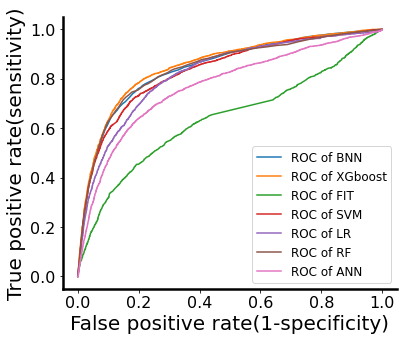

In [152]:
#Fig5A in pros_data



pros_y = np.array(pros_data['癌'])
pros_X = pros_data.drop(['癌'], axis=1)
y = np.array(simplified_data['癌'])
X = simplified_data.drop(['癌'], axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X).astype(np.float32)
pros_X = scaler.transform(pros_X).astype(np.float32)

X_train = X
X_test = pros_X


result,y_pred_class_BNN = BNN_algo(X,pros_X,y,pros_y)
result,y_pred_class_FIT = FOBAlgo(y,pros_y)

fpr_1, tpr_1, thresholds = metrics.roc_curve(pros_y, y_pred_class_BNN.mean(1)) #BNN
fpr_3, tpr_3, thresholds = metrics.roc_curve(pros_y, y_pred_class_FIT[:,1]) #FIT



result,y_pred_class_XGB = XGboostAlgo(X,pros_X,y,pros_y)
result,y_pred_class_SVM = SVMALGO(X,pros_X,y,pros_y)
result,y_pred_class_Logistic = LogisticAlgo(X,pros_X,y,pros_y)
result,y_pred_class_RF = RandomForestALGO(X,pros_X,y,pros_y)
result,y_pred_class_MLP = MLPALGO(X,pros_X,y,pros_y)

fpr_2, tpr_2, thresholds = metrics.roc_curve(pros_y, y_pred_class_XGB[:,1]) #XGBoost
fpr_5, tpr_5, thresholds = metrics.roc_curve(pros_y, y_pred_class_SVM[:,1]) #SVM
fpr_6, tpr_6, thresholds = metrics.roc_curve(pros_y, y_pred_class_Logistic[:,1]) #Logistic
fpr_7, tpr_7, thresholds = metrics.roc_curve(pros_y, y_pred_class_RF[:,1]) #Random Forest
fpr_8, tpr_8, thresholds = metrics.roc_curve(pros_y, y_pred_class_MLP[:,1]) #Neuron Network

#roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
#plt.plot(fpr_3,tpr_3)


f, ax= plt.subplots(figsize = (6, 5))
fig=plt.plot(fpr_1,tpr_1,label="ROC of BNN")
fig=plt.plot(fpr_2,tpr_2,label="ROC of XGboost")
fig=plt.plot(fpr_3,tpr_3,label="ROC of FIT")
fig=plt.plot(fpr_5,tpr_5,label="ROC of SVM")
fig=plt.plot(fpr_6,tpr_6,label="ROC of LR")
fig=plt.plot(fpr_7,tpr_7,label="ROC of RF")
fig=plt.plot(fpr_8,tpr_8,label="ROC of ANN")

# 设置Axes的标题
#ax.set_title('ROC curve compare')
ax.set_xlabel("False positive rate(1-specificity)",fontsize=20)
ax.set_ylabel("True positive rate(sensitivity)",fontsize=20)
ax.tick_params(labelsize=16) 
ax.legend(fontsize=12)

for spine in ax.spines.values():
    spine.set_linewidth(2.5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#ax.annotate('(d)', xy=(1, 1), xytext=(0, 1),xycoords="figure fraction",fontsize=20)


plt.savefig(r"D:\HKUST\Program\结肠癌分类器\审稿\pros_Fig5Anew.png",dpi=800,bbox_inches='tight',pad_inches=0.2)
#plt.savefig(r"D:\HKUST\Program\结肠癌分类器\终稿\论文图片精修\图片修改v2\Fig5A.png",dpi=800,bbox_inches='tight',pad_inches=0.2)

#plt.show()

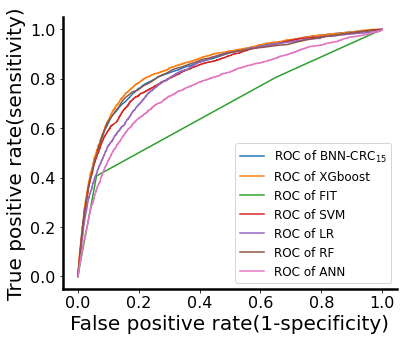

In [167]:


f, ax= plt.subplots(figsize = (6, 5))
fig=plt.plot(fpr_1,tpr_1,label="ROC of BNN-CRC$_{15}$")
fig=plt.plot(fpr_2,tpr_2,label="ROC of XGboost")
fig=plt.plot(fpr_3,tpr_3,label="ROC of FIT")
fig=plt.plot(fpr_5,tpr_5,label="ROC of SVM")
fig=plt.plot(fpr_6,tpr_6,label="ROC of LR")
fig=plt.plot(fpr_7,tpr_7,label="ROC of RF")
fig=plt.plot(fpr_8,tpr_8,label="ROC of ANN")

# 设置Axes的标题
#ax.set_title('ROC curve compare')
ax.set_xlabel("False positive rate(1-specificity)",fontsize=20)
ax.set_ylabel("True positive rate(sensitivity)",fontsize=20)
ax.tick_params(labelsize=16) 
ax.legend(fontsize=12)

for spine in ax.spines.values():
    spine.set_linewidth(2.5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#ax.annotate('(d)', xy=(1, 1), xytext=(0, 1),xycoords="figure fraction",fontsize=20)


plt.savefig(r"D:\HKUST\Program\结肠癌分类器\审稿\pros_Fig5Anew.png",dpi=800,bbox_inches='tight',pad_inches=0.2)
#plt.savefig(r"D:\HKUST\Program\结肠癌分类器\终稿\论文图片精修\图片修改v2\Fig5A.png",dpi=800,bbox_inches='tight',pad_inches=0.2)

#plt.show()

### Calibration


In [17]:
y_pred_BNN = BNN_algo(X_train,X_test,y_train,y_test)
y_pred_XGB = XGboostAlgo(X_train,X_test,y_train,y_test)
y_pred_FIT = FOBAlgo(y_train,y_test)

  0%|          | 0/2001 [00:00<?, ?it/s]

C:\Users\Wu Zihao\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:09:29] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Wu Zihao\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:09:30] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


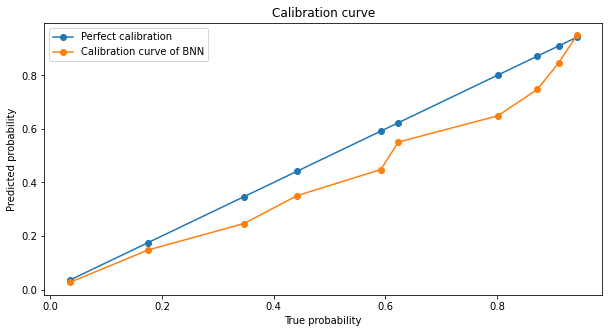

In [20]:
from sklearn.calibration import calibration_curve


f, ax= plt.subplots(figsize = (10, 5))
prob_true, prob_pred_BNN = calibration_curve(y_test, np.mean(y_pred_BNN[1],axis=1), n_bins=10,strategy="uniform")
fig=plt.plot(prob_true,prob_true,label="Perfect calibration",marker="o")
fig=plt.plot(prob_true,prob_pred_BNN,label="Calibration curve of BNN",marker="o")
#prob_true, prob_pred_XGB = calibration_curve(y_test, y_pred_XGB[1][:,1], n_bins=10,strategy="uniform")
#fig=plt.plot(prob_true,prob_pred_XGB,label="Calibration curve of XGB",marker="o")
#prob_true, prob_pred_FIT = calibration_curve(y_test, y_pred_FIT[1][:,1], n_bins=10,strategy="uniform")
#fig=plt.plot(prob_true,prob_pred_FIT,label="Calibration curve of FIT",marker="o")

ax.set_title('Calibration curve')
ax.set_xlabel("True probability")
ax.set_ylabel("Predicted probability")
ax.legend()
plt.show()

In [21]:
from sklearn import feature_selection
import scipy

In [15]:
def HL_test(Og,Eg,Ng):
    HL=0
    assert len(Og)==len(Eg)
    for i in range(len(Og)):
        HL+=min(100,(Og[i]-Eg[i])**2)/Eg[i]/max(0.1,1-Eg[i]/Ng)
        print(min(100,(Og[i]-Eg[i])**2)/Eg[i]/max(0.1,1-Eg[i]/Ng))
    return HL

In [16]:
prob_true, prob_pred_BNN = calibration_curve(y_test, np.mean(y_pred_BNN[1],axis=1), n_bins=10,strategy="uniform")
Eg=[]
Og=[]
Ng=558
for i in range(len(prob_true)):
    Og.append(int(prob_true[i]*Ng))
    Eg.append(int(prob_pred_BNN[i]*Ng))

H=HL_test(Og,Eg,Ng)
#scipy.stats.chisquare()
P_value = 1-scipy.stats.chi2.cdf(x=H,df=8)
H,P_value

NameError: name 'y_pred_BNN' is not defined

In [24]:
prob_true, prob_pred_XGB = calibration_curve(y_test, y_pred_XGB[1][:,1], n_bins=10,strategy="uniform")
Eg=[]
Og=[]
Ng=558
for i in range(len(prob_true)):
    Og.append(int(prob_true[i]*Ng))
    Eg.append(int(prob_pred_XGB[i]*Ng))

H=HL_test(Og,Eg,Ng)
#scipy.stats.chisquare()
P_value = 1-scipy.stats.chi2.cdf(x=H,df=8)
H,P_value

4.534741974806988
0.37259615384615385
0.15403726708074533
0.7901891922510479
0.7236227824463118
0.46311858076563955
0.7883026064844246
0.9627329192546583
1.429596228735396
0.30245746691871456


(10.52139517259008, 0.23031900243833114)

In [17]:
prob_true, prob_pred_BNN = calibration_curve(y_test, np.mean(y_pred_FIT[1],axis=1), n_bins=10,strategy="uniform")
Eg=[]
Og=[]
Ng=558
for i in range(len(prob_true)):
    Og.append(int(prob_true[i]*Ng))
    Eg.append(int(prob_pred_FIT[i]*Ng))

H=HL_test(Og,Eg,Ng)
#scipy.stats.chisquare()
P_value = 1-scipy.stats.chi2.cdf(x=H,df=1)
H,P_value

NameError: name 'y_pred_FIT' is not defined

### Logistics

In [26]:
result,y_pred=LogisticAlgo(X_train,X_test,y_train,y_test)
y_pred

C:\Users\Wu Zihao\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([[0.57882099, 0.42117901],
       [0.97040458, 0.02959542],
       [0.02069945, 0.97930055],
       ...,
       [0.94626657, 0.05373343],
       [0.44679298, 0.55320702],
       [0.30068459, 0.69931541]])

In [27]:
classfier_model =XGBClassifier(max_depth=2)
classfier_model.fit(X_train,y_train)
y_pred_class = classfier_model.predict_proba(X_test)

y_pred_class

C:\Users\Wu Zihao\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:17:09] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


array([[0.6643066 , 0.33569342],
       [0.98911697, 0.01088304],
       [0.02187753, 0.9781225 ],
       ...,
       [0.9293193 , 0.07068069],
       [0.31635368, 0.6836463 ],
       [0.49144787, 0.50855213]], dtype=float32)

In [38]:
### The best one in K-fold
m=[];
for train,split in kf.split(X):
    m.append([train,split])
train=m[6][0]
test=m[6][1]

X_train=X.loc[train, :]
X_test=X.loc[test,:]
y_train=y[train]
y_test=y[test]
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_test = scaler.transform(X_test).astype(np.float32)

result,y_pred_class = BNN_algo(X_train,X_test,y_train,y_test)
result

  0%|          | 0/2001 [00:00<?, ?it/s]

[0.8771049802938015,
 0.8591709277051683,
 0.8764534818056432,
 0.8010362694300518,
 0.9173055859802848,
 0.8365800865800865,
 0.8971612212104981,
 44.6597337196468]

In [20]:
###K-fold
results = [];
K=10
#kf = KFold(n_splits=K)
for train,test in kf.split(X):
    # K-fold 
    X_train=X.loc[train, :]
    X_test=X.loc[test,:]
    y_train=y[train]
    y_test=y[test]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train).astype(np.float32)
    X_test = scaler.transform(X_test).astype(np.float32)
    
    result,y_pred_class = BNN_algo(X_train,X_test,y_train,y_test)
    #result,y_pred_class = XGboostAlgo(X_train,X_test,y_train,y_test)
    #result,y_pred_class = FOBAlgo(y_train,y_test)
    
    results.append(result)
    

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

In [20]:
### Simple train-test spilt

## Standard features
y = np.array(df['癌'])
#X = df.drop(['PATIENT_ID', '癌'], axis=1)
X = df.drop(['癌'], axis=1)
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state= 42)
original_x_test=X_test.copy()
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_test = scaler.transform(X_test).astype(np.float32)

result,y_pred_class_BNN = BNN_algo(X_train,X_test,y_train,y_test)
result,y_pred_class_XGB = XGboostAlgo(X_train,X_test,y_train,y_test)
result,y_pred_class_FIT = FOBAlgo(y_train,y_test)

## Simplified features
y = np.array(simplified_merged['癌'])
#X = df.drop(['PATIENT_ID', '癌'], axis=1)
X = simplified_merged.drop(['癌'], axis=1)
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state= 42)
original_x_test=X_test.copy()
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_test = scaler.transform(X_test).astype(np.float32)

result,y_pred_class_simplified_BNN = BNN_algo(X_train,X_test,y_train,y_test)

  0%|          | 0/2001 [00:00<?, ?it/s]

C:\Users\Wu Zihao\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:10:27] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Wu Zihao\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:10:28] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


  0%|          | 0/2001 [00:00<?, ?it/s]

In [82]:
df

,Age,WBC,Lym,Mon,Ne,Eos,Baso,Lym%,Mon%,Eos%,Baso%,Ne%,RBC,Hb,HCT,MCV,MCH,MCHC,RDW,PLT,MPV,PCT,PDW,P-LCR,Urea,Na+,K+,Cl-,Glu,Creatinine,CO₂CP,Uric Acid,CA19-9,TBIL,DBIL,TP,ALB,Globulin,A/G,ALT,AST,ALP,TBA,γ-GT,Prealbumin,LDH,IBIL,CEA,FIT positive,FIT's data is missing',Fecal transferrin positive,Fecal transferrin's data is missing',Gender,BMI,癌
0,61,4.16,1.09,0.52,2.53,0.00,0.02,26.2,12.5,0.0,0.5,60.8,5.08,173.0,48.4,95.3,34.1,357.0,13.6,99.0,9.5,0.09,10.7,21.9,4.1,141.0,4.5,101.0,5.6,86.0,27.0,0.36,22.504914,5.3,2.4,69.0,39.0,30.0,1.30,44.0,41.0,80.0,5.1,51.0,147.00000,249.0,2.9,8.699406,0,1,0,1,1.00000,22.222222,0
1,73,3.63,0.75,0.17,2.67,0.04,0.00,20.7,4.7,1.1,0.0,73.5,4.81,149.0,43.5,90.4,31.0,343.0,12.9,101.0,10.4,0.11,12.4,28.0,4.0,142.0,4.0,106.0,4.0,56.0,26.0,0.26,22.504914,19.4,6.9,72.0,47.0,25.0,1.88,16.0,22.0,68.0,6.5,38.0,192.00000,152.0,12.5,8.699406,0,1,0,1,1.00000,25.826446,0
2,84,3.65,1.33,0.22,1.98,0.10,0.02,36.4,6.0,2.7,0.5,54.4,3.68,122.0,35.2,95.7,33.2,347.0,12.8,167.0,9.2,0.15,9.5,17.6,3.9,136.0,4.2,97.0,6.3,80.0,25.0,0.21,27.910000,5.3,1.6,70.0,43.0,27.0,1.59,6.0,17.0,109.0,2.2,26.0,210.00000,126.0,3.7,1.690000,0,1,0,1,0.00000,19.531250,0
3,71,7.29,1.79,0.30,5.08,0.12,0.00,24.6,4.1,1.6,0.0,69.7,3.84,125.0,37.2,96.9,32.6,336.0,12.4,187.0,9.6,0.18,10.4,21.6,8.3,146.0,4.1,105.0,5.6,85.0,26.0,0.27,22.504914,7.3,2.2,74.0,45.0,29.0,1.55,14.0,16.0,38.0,10.1,11.0,225.49881,146.0,5.1,8.699406,0,1,0,1,0.63176,23.857203,0
4,80,5.68,1.81,0.37,3.36,0.12,0.02,31.9,6.5,2.1,0.4,59.1,3.06,99.0,27.9,91.2,32.4,355.0,11.6,175.0,9.2,0.16,9.1,17.7,4.9,132.0,3.8,100.0,9.7,66.0,26.0,0.38,22.504914,7.7,2.3,63.0,37.0,26.0,1.42,11.0,18.0,66.0,2.3,18.0,199.00000,143.0,5.4,3.630000,0,1,0,1,0.00000,29.968783,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27906,56,5.51,1.82,0.45,3.04,0.17,0.03,33.0,8.2,3.1,0.5,55.2,4.24,132.0,39.1,92.2,31.1,338.0,12.0,203.0,10.5,0.21,11.9,28.6,7.7,143.0,4.1,110.0,5.2,98.0,23.0,0.53,22.504914,13.2,3.9,62.0,37.0,25.0,1.48,22.0,13.0,106.0,2.8,82.0,257.00000,139.0,9.3,8.699406,0,1,0,1,1.00000,28.081633,0
27907,76,5.71,1.81,0.35,3.48,0.03,0.04,31.7,6.1,0.5,0.7,61.0,3.93,115.0,36.0,91.6,29.3,319.0,12.0,229.0,10.2,0.23,10.8,25.5,4.3,143.0,4.3,108.0,4.1,79.0,23.0,0.34,22.504914,6.0,2.1,62.0,36.0,26.0,1.38,11.0,18.0,97.0,2.3,23.0,228.00000,151.0,3.9,8.699406,0,1,0,1,0.00000,26.175195,0
27908,65,5.99,1.79,0.73,2.92,0.48,0.07,29.9,12.2,8.0,1.2,48.7,4.21,126.0,38.5,91.4,29.9,327.0,13.0,206.0,13.1,0.27,19.0,50.4,6.1,142.0,3.9,109.0,4.0,78.0,23.0,0.36,22.504914,10.9,3.3,63.0,40.0,23.0,1.74,11.0,14.0,78.0,2.2,14.0,213.00000,195.0,7.6,1.280000,0,1,0,1,1.00000,18.591130,0
27909,52,6.72,2.11,0.49,3.86,0.21,0.05,31.4,7.3,3.1,0.7,57.5,4.33,132.0,39.0,90.1,30.5,338.0,12.6,326.0,10.3,0.34,11.7,27.3,4.1,139.0,4.1,102.0,4.9,62.0,29.0,0.35,7.480000,8.7,1.2,80.0,49.0,31.0,1.58,22.0,30.0,100.0,20.1,52.0,310.00000,183.0,7.5,0.750000,0,0,0,0,0.00000,24.243918,0


In [133]:
#standard_data
#pd.DataFrame(results).to_excel(r"D:\HKUST\Program\结肠癌分类器\终稿\去粪指标修改\Table3a.xlsx")
#simplified data
#pd.DataFrame(results).to_excel(r"D:\HKUST\Program\结肠癌分类器\终稿\去粪指标修改\Table3b.xlsx")

In [19]:
y = np.array(df['癌'])
#X = df.drop(['PATIENT_ID', '癌'], axis=1)
X = df.drop(['癌'], axis=1)
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state= 42)
original_x_test=X_test.copy()
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_test = scaler.transform(X_test).astype(np.float32)


result,y_pred_class_XGB = XGboostAlgo(X_train,X_test,y_train,y_test)


C:\Users\Wu Zihao\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:08:02] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [135]:
result,y_pred_class_simplified_BNN = BNN_algo(X_train,X_test,y_train,y_test)

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

C:\Users\Wu Zihao\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Wu Zihao\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:16:36] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:16:36] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


  0%|          | 0/2001 [00:00<?, ?it/s]

C:\Users\Wu Zihao\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


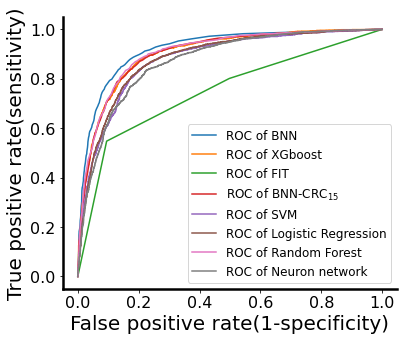

In [140]:
#Fig5A

#Using Full Data 


y = np.array(df['癌'])
#X = df.drop(['PATIENT_ID', '癌'], axis=1)
X = df.drop(['癌'], axis=1)
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state= 42)
original_x_test=X_test.copy()
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_test = scaler.transform(X_test).astype(np.float32)


result,y_pred_class_BNN = BNN_algo(X_train,X_test,y_train,y_test)
result,y_pred_class_FIT = FOBAlgo(y_train,y_test)

fpr_1, tpr_1, thresholds = metrics.roc_curve(y_test, y_pred_class_BNN.mean(1)) #BNN

fpr_3, tpr_3, thresholds = metrics.roc_curve(y_test, y_pred_class_FIT[:,1]) #FIT


#Using Simplified Data

y = np.array(simplified_data['癌'])
#X = df.drop(['PATIENT_ID', '癌'], axis=1)
X = simplified_data.drop(['癌'], axis=1)
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state= 42)
original_x_test=X_test.copy()
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_test = scaler.transform(X_test).astype(np.float32)

result,y_pred_class_XGB = XGboostAlgo(X_train,X_test,y_train,y_test)
result,y_pred_class_simplified_BNN = BNN_algo(X_train,X_test,y_train,y_test)
result,y_pred_class_SVM = SVMALGO(X_train,X_test,y_train,y_test)
result,y_pred_class_Logistic = LogisticAlgo(X_train,X_test,y_train,y_test)
result,y_pred_class_RF = RandomForestALGO(X_train,X_test,y_train,y_test)
result,y_pred_class_MLP = MLPALGO(X_train,X_test,y_train,y_test)

fpr_2, tpr_2, thresholds = metrics.roc_curve(y_test, y_pred_class_XGB[:,1]) #XGBoost
fpr_4, tpr_4, thresholds = metrics.roc_curve(y_test, y_pred_class_simplified_BNN.mean(1)) #simplified BNN
fpr_5, tpr_5, thresholds = metrics.roc_curve(y_test, y_pred_class_SVM[:,1]) #SVM
fpr_6, tpr_6, thresholds = metrics.roc_curve(y_test, y_pred_class_Logistic[:,1]) #Logistic
fpr_7, tpr_7, thresholds = metrics.roc_curve(y_test, y_pred_class_RF[:,1]) #Random Forest
fpr_8, tpr_8, thresholds = metrics.roc_curve(y_test, y_pred_class_MLP[:,1]) #Neuron Network

#roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
#plt.plot(fpr_3,tpr_3)


f, ax= plt.subplots(figsize = (6, 5))
fig=plt.plot(fpr_1,tpr_1,label="ROC of BNN")
fig=plt.plot(fpr_2,tpr_2,label="ROC of XGboost")
fig=plt.plot(fpr_3,tpr_3,label="ROC of FIT")
fig=plt.plot(fpr_4,tpr_4,label="ROC of BNN-CRC$_{15}$")
fig=plt.plot(fpr_5,tpr_5,label="ROC of SVM")
fig=plt.plot(fpr_6,tpr_6,label="ROC of LR")
fig=plt.plot(fpr_7,tpr_7,label="ROC of RF")
fig=plt.plot(fpr_8,tpr_8,label="ROC of ANN")

# 设置Axes的标题
#ax.set_title('ROC curve compare')
ax.set_xlabel("False positive rate(1-specificity)",fontsize=20)
ax.set_ylabel("True positive rate(sensitivity)",fontsize=20)
ax.tick_params(labelsize=16) 
ax.legend(fontsize=12)

for spine in ax.spines.values():
    spine.set_linewidth(2.5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#ax.annotate('(d)', xy=(1, 1), xytext=(0, 1),xycoords="figure fraction",fontsize=20)


plt.savefig(r"D:\HKUST\Program\结肠癌分类器\审稿\Fig5Anew.png",dpi=800,bbox_inches='tight',pad_inches=0.2)
#plt.savefig(r"D:\HKUST\Program\结肠癌分类器\终稿\论文图片精修\图片修改v2\Fig5A.png",dpi=800,bbox_inches='tight',pad_inches=0.2)

#plt.show()


In [161]:
a=np.array(results)
a[:,7].mean()
x=pd.DataFrame(a)
x.to_excel(r"D:\HKUST\Program\结肠癌分类器\终稿\3. results\method_compare.xlsx")

In [ ]:
y = np.array(df['癌'])
#X = df.drop(['PATIENT_ID', '癌'], axis=1)
X = df.drop(['癌'], axis=1)
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state= 42)
original_x_test=X_test.copy()
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_test = scaler.transform(X_test).astype(np.float32)

In [316]:
original_x_test

,Age,WBC,Lym,Mon,Ne,Eos,Baso,Lym%,Mon%,Eos%,Baso%,Ne%,RBC,Hb,HCT,MCV,MCH,MCHC,RDW,PLT,MPV,PCT,PDW,P-LCR,Urea,Na+,K+,Cl-,Glu,Creatinine,CO₂CP,Uric Acid,CA19-9,TBIL,DBIL,TP,ALB,Globulin,A/G,ALT,AST,ALP,TBA,γ-GT,Prealbumin,LDH,IBIL,CEA,FIT positive,FIT's data is missing',Fecal transferrin positive,Fecal transferrin's data is missing',Gender,BMI
3834,53,3.79,1.59,0.30,1.86,0.03,0.01,42.0,7.9,0.8,0.3,49.0,4.21,137.0,0.4,94.5,32.5,344.0,12.6,152.0,13.9,0.21,23.7,54.8,4.4,140.0,3.8,106.0,5.8,50.0,28.0,321.00,22.504914,14.4,3.9,77.0,40.0,37.0,1.08,24.0,17.0,87.0,3.9,15.0,213.0,130.000000,10.5,2.220000,0,0,0,1,0.63176,23.857203
26271,37,9.94,2.21,0.55,7.12,0.03,0.03,22.2,5.5,0.3,0.3,71.7,4.55,125.0,38.6,84.8,27.5,324.0,12.2,276.0,9.9,0.27,10.6,23.7,3.1,141.0,4.2,106.0,4.7,69.0,23.0,0.32,22.504914,13.2,4.5,68.0,42.0,26.0,1.62,14.0,14.0,40.0,1.6,13.0,223.0,151.000000,4.8,8.699406,0,1,0,1,0.00000,26.672763
16443,70,5.07,1.80,0.49,2.52,0.23,0.03,35.4,9.7,4.6,0.6,49.7,3.48,105.0,33.0,94.9,30.3,319.0,17.6,135.0,7.9,0.11,15.8,12.8,5.4,141.0,4.2,97.0,5.6,52.0,26.0,0.27,40.190000,10.6,2.9,74.0,40.0,34.0,1.18,10.0,18.0,67.0,3.0,13.0,162.0,203.000000,7.7,5.940000,1,0,0,1,0.00000,23.875433
9427,58,3.79,0.77,0.18,2.81,0.02,0.01,20.3,4.7,0.5,0.3,74.2,4.78,141.0,42.5,88.9,29.5,332.0,12.2,163.0,10.2,0.17,11.9,26.3,3.2,142.0,4.2,105.0,6.3,49.0,26.0,0.19,2.300000,12.5,1.8,73.0,48.0,25.0,1.92,25.0,27.0,71.0,2.4,23.0,164.0,229.000000,10.7,5.690000,0,1,0,1,0.00000,22.892820
6316,66,4.43,1.97,0.25,2.09,0.10,0.02,44.5,5.6,2.3,0.5,47.1,4.34,123.0,38.9,89.6,28.3,316.0,13.0,329.0,9.7,0.32,10.7,21.4,5.8,141.0,3.8,103.0,6.0,48.0,26.0,0.22,22.504914,15.1,3.4,71.0,45.0,26.0,1.73,10.0,17.0,77.0,1.2,15.0,272.0,179.751026,11.7,8.699406,0,1,0,1,0.00000,24.034610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15660,31,7.06,1.78,0.33,4.84,0.08,0.03,25.2,4.7,1.1,0.4,68.6,5.35,147.0,45.2,84.5,27.5,325.0,13.0,292.0,11.1,0.33,13.4,33.7,5.4,139.0,4.4,104.0,5.6,83.0,26.0,0.36,22.504914,8.2,1.4,72.0,47.0,25.0,1.88,20.0,18.0,66.0,6.9,37.0,337.0,141.000000,6.8,8.699406,0,1,0,1,0.63176,23.857203
17907,56,4.79,0.60,0.38,3.66,0.13,0.02,12.5,8.0,2.6,0.4,76.5,3.90,115.0,35.1,89.9,29.5,328.0,14.3,315.0,8.6,0.27,15.8,16.7,6.4,143.0,4.1,105.0,5.3,60.0,26.0,0.28,32.130000,18.9,2.8,77.0,46.0,31.0,1.48,109.0,48.0,71.0,9.5,41.0,234.0,250.000000,16.1,3.410000,0,0,1,0,0.00000,22.516910
10128,71,4.82,2.43,0.23,2.09,0.05,0.02,50.4,4.8,1.0,0.4,43.4,4.13,136.0,40.1,97.1,32.9,339.0,12.8,203.0,10.2,0.21,11.1,26.0,3.6,145.0,3.7,105.0,5.5,68.0,26.0,0.19,4.960000,25.5,8.9,69.0,38.0,31.0,1.23,11.0,18.0,96.0,12.1,17.0,172.0,176.000000,16.6,1.700000,0,0,0,0,0.00000,27.425048
15533,80,6.15,1.58,0.43,3.98,0.12,0.04,25.7,7.0,1.9,0.7,64.7,4.44,131.0,39.4,88.7,29.4,332.0,13.2,195.0,8.6,0.17,16.0,16.4,8.9,143.0,4.6,101.0,5.7,59.0,26.0,0.35,12.710000,9.8,2.7,75.0,45.0,30.0,1.50,11.0,14.0,92.0,4.6,28.0,226.0,255.000000,7.1,2.320000,1,0,1,0,1.00000,21.231206


  0%|          | 0/2001 [00:00<?, ?it/s]

[[0 0 1 ... 0 1 1]
 [0 0 0 ... 0 0 0]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 1 0 1]
 [1 1 1 ... 1 1 1]]


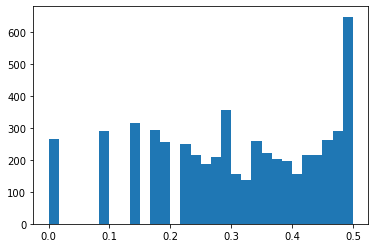

[0. 0. 1. ... 0. 1. 1.]
0.4712520150456744


In [18]:
model = Model(d_in=X_train.shape[1], h1=200, h2=None)
guide = AutoDiagonalNormal(model)
optim = pyro.optim.Adam({"lr": 0.01})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

pyro.clear_param_store()
bar = trange(2001)
x_torch = torch.from_numpy(X_train).float()
y_torch = torch.from_numpy(y_train).float()
for epoch in bar:
    loss = svi.step(x_torch, y_torch)
    bar.set_postfix(loss=f'{loss / X_train.shape[0]:.3f}')


num_samples = 101
predictive = Predictive(model, guide=guide, num_samples=num_samples)
preds = predictive(torch.from_numpy(X_test).float()) #对test数据
#preds = predictive(torch.from_numpy(X).float())

y_pred = preds['obs'].T.detach().numpy()
print(y_pred)

uncertainty = np.std(y_pred, axis=1)
plt.hist(uncertainty, bins=30)
plt.show()

y_pred_class = np.median(y_pred,axis=1)
y_pred_prob = np.mean(y_pred,axis=1)
print(y_pred_class)

is_confident = uncertainty < 0.3
print(sum(is_confident)/len(uncertainty))

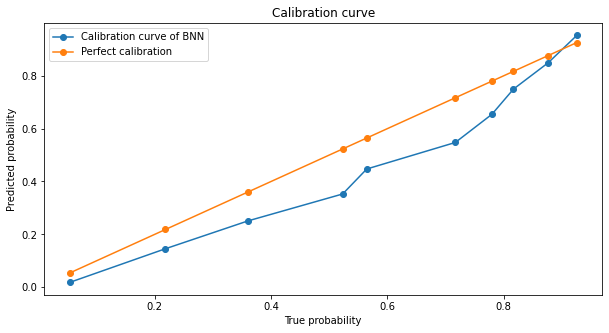

In [27]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, y_pred_prob, n_bins=10,strategy="uniform")
prob_true, prob_pred


f, ax= plt.subplots(figsize = (10, 5))
fig=plt.plot(prob_true,prob_pred,label="Calibration curve of BNN",marker="o")
fig=plt.plot(prob_true,prob_true,label="Perfect calibration",marker="o")
ax.set_title('Calibration curve')
ax.set_xlabel("True probability")
ax.set_ylabel("Predicted probability")
ax.legend()
plt.show()

In [323]:
original_x_test[is_confident]

,Age,WBC,Lym,Mon,Ne,Eos,Baso,Lym%,Mon%,Eos%,Baso%,Ne%,RBC,Hb,HCT,MCV,MCH,MCHC,RDW,PLT,MPV,PCT,PDW,P-LCR,Urea,Na+,K+,Cl-,Glu,Creatinine,CO₂CP,Uric Acid,CA19-9,TBIL,DBIL,TP,ALB,Globulin,A/G,ALT,AST,ALP,TBA,γ-GT,Prealbumin,LDH,IBIL,CEA,FIT positive,FIT's data is missing',Fecal transferrin positive,Fecal transferrin's data is missing',Gender,BMI
26271,37,9.94,2.21,0.55,7.12,0.03,0.03,22.2,5.5,0.3,0.3,71.7,4.55,125.0,38.6,84.8,27.5,324.0,12.2,276.0,9.9,0.27,10.6,23.700000,3.100000,141.000000,4.200000,106.000000,4.7,69.0,23.000000,0.32,22.504914,13.2,4.5,68.0,42.0,26.0,1.62,14.0,14.0,40.0,1.6,13.0,223.0,151.000000,4.8,8.699406,0,1,0,1,0.00000,26.672763
16443,70,5.07,1.80,0.49,2.52,0.23,0.03,35.4,9.7,4.6,0.6,49.7,3.48,105.0,33.0,94.9,30.3,319.0,17.6,135.0,7.9,0.11,15.8,12.800000,5.400000,141.000000,4.200000,97.000000,5.6,52.0,26.000000,0.27,40.190000,10.6,2.9,74.0,40.0,34.0,1.18,10.0,18.0,67.0,3.0,13.0,162.0,203.000000,7.7,5.940000,1,0,0,1,0.00000,23.875433
9427,58,3.79,0.77,0.18,2.81,0.02,0.01,20.3,4.7,0.5,0.3,74.2,4.78,141.0,42.5,88.9,29.5,332.0,12.2,163.0,10.2,0.17,11.9,26.300000,3.200000,142.000000,4.200000,105.000000,6.3,49.0,26.000000,0.19,2.300000,12.5,1.8,73.0,48.0,25.0,1.92,25.0,27.0,71.0,2.4,23.0,164.0,229.000000,10.7,5.690000,0,1,0,1,0.00000,22.892820
6316,66,4.43,1.97,0.25,2.09,0.10,0.02,44.5,5.6,2.3,0.5,47.1,4.34,123.0,38.9,89.6,28.3,316.0,13.0,329.0,9.7,0.32,10.7,21.400000,5.800000,141.000000,3.800000,103.000000,6.0,48.0,26.000000,0.22,22.504914,15.1,3.4,71.0,45.0,26.0,1.73,10.0,17.0,77.0,1.2,15.0,272.0,179.751026,11.7,8.699406,0,1,0,1,0.00000,24.034610
20394,53,9.72,0.66,0.36,8.61,0.07,0.02,6.8,3.7,0.7,0.2,88.6,3.35,117.0,35.3,105.5,35.0,332.0,18.5,79.0,9.5,0.08,15.9,22.300000,4.500000,147.000000,3.800000,107.000000,5.6,47.0,29.000000,0.14,238.180000,12.3,5.5,63.0,42.0,21.0,2.00,18.0,21.0,78.0,0.8,17.0,116.0,210.000000,6.8,36.730000,1,0,1,0,0.00000,24.835763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18079,65,7.51,2.04,0.33,5.00,0.11,0.03,27.2,4.4,1.5,0.4,66.5,4.91,154.0,44.7,91.1,31.3,344.0,12.2,272.0,7.7,0.21,15.9,12.400000,5.000000,139.000000,4.300000,106.000000,5.5,70.0,24.000000,0.41,22.504914,7.7,2.2,69.0,43.0,26.0,1.65,20.0,18.0,79.0,3.6,22.0,275.0,149.000000,5.5,2.850000,0,0,0,0,1.00000,24.508946
9240,36,6.51,1.94,0.33,4.03,0.18,0.03,29.7,5.1,2.9,0.4,61.9,4.67,139.0,40.0,85.5,29.8,348.0,12.6,266.0,7.8,0.21,15.6,28.324203,5.225662,141.780249,4.062808,103.598318,5.4,77.0,25.941884,0.32,2.660000,10.7,4.1,76.0,46.0,30.0,1.53,20.0,17.0,84.0,1.1,18.0,188.0,165.000000,6.6,1.670000,0,1,0,1,0.63176,23.857203
408,77,6.52,2.07,0.40,3.71,0.30,0.04,31.7,6.1,4.6,0.6,57.0,4.34,129.0,40.0,92.2,29.7,323.0,12.3,219.0,12.0,0.26,14.7,42.000000,7.000000,146.000000,3.700000,107.000000,6.3,72.0,24.000000,0.46,22.504914,9.5,2.6,71.0,41.0,30.0,1.37,13.0,16.0,58.0,5.9,15.0,274.0,166.000000,6.9,8.699406,0,1,0,1,0.00000,25.289419
15660,31,7.06,1.78,0.33,4.84,0.08,0.03,25.2,4.7,1.1,0.4,68.6,5.35,147.0,45.2,84.5,27.5,325.0,13.0,292.0,11.1,0.33,13.4,33.700000,5.400000,139.000000,4.400000,104.000000,5.6,83.0,26.000000,0.36,22.504914,8.2,1.4,72.0,47.0,25.0,1.88,20.0,18.0,66.0,6.9,37.0,337.0,141.000000,6.8,8.699406,0,1,0,1,0.63176,23.857203


### Deal with confident data

In [88]:
a=X_test[is_confident]
b=y_test[is_confident]
#s=np.concatenate((a,b))
s=pd.DataFrame(a)
s.insert(loc=len(s.columns),column="癌",value=b)
s.columns=df.columns

In [89]:
a=X_test
b=y_test
#s=np.concatenate((a,b))
test_data=pd.DataFrame(a)
test_data.insert(loc=len(test_data.columns),column="癌",value=b)
test_data.columns=df.columns
test_data

,Age,WBC,Lym,Mon,Ne,Eos,Baso,Lym%,Mon%,Eos%,Baso%,Ne%,RBC,Hb,HCT,MCV,MCH,MCHC,RDW,PLT,MPV,PCT,PDW,P-LCR,Urea,Na+,K+,Cl-,Glu,Creatinine,CO₂CP,Uric Acid,CA19-9,TBIL,DBIL,TP,ALB,Globulin,A/G,ALT,AST,ALP,TBA,γ-GT,Prealbumin,LDH,IBIL,CEA,FIT positive,FIT's data is missing',Fecal transferrin positive,Fecal transferrin's data is missing',Gender,BMI,癌
0,-0.321170,-0.751142,-0.231292,-0.787063,-0.997882,-0.718385,-0.856183,1.215407,0.231042,-0.693820,-0.410655,-1.010666,-0.262418,0.251758,-5.160348,0.493591,0.780067,0.801736,-0.487350,-0.739815,2.712691,0.076330,3.594583,2.784773,-0.395632,-0.603745,-0.711534,0.808292,0.005918,-0.678927,1.215428,9.269355,0.003320,0.045179,-0.052700,1.198161,-0.336224,2.045328,-1.588859,-0.060339,-0.279996,0.108339,-0.161546,-0.409657,-0.178580,-0.588454,0.194779,-0.134483,-0.601909,-0.696752,-0.439016,1.048092,-0.002358,-0.018734,0
1,-1.576188,1.012154,0.640460,0.539700,1.444866,-0.718385,0.255118,-0.645239,-0.687320,-0.910530,-0.410655,0.933666,0.305589,-0.375245,-0.045214,-0.966759,-1.019702,-0.562704,-0.636661,1.144530,-0.313353,0.977817,-1.247171,-0.482917,-1.021377,-0.265464,0.364480,0.808292,-0.671045,-0.072289,-1.757016,-0.110424,0.003320,-0.060668,0.031457,-0.154796,0.041443,-0.399199,0.364982,-0.422594,-0.383139,-0.724322,-0.379268,-0.438452,-0.037807,-0.341255,-0.886306,-0.001143,-0.601909,1.435231,-0.439016,1.048092,-1.385353,0.039417,0
2,1.012286,-0.384147,0.063979,0.221277,-0.691378,0.516217,0.255118,0.595192,0.919814,0.953176,0.616307,-0.950709,-1.481963,-1.420249,-0.795076,0.553812,-0.011832,-0.903813,1.379048,-0.998153,-1.826375,-1.426148,0.674746,-1.628184,0.085711,-0.265464,0.364480,-2.205950,-0.117167,-0.615070,0.026450,-0.111886,0.290024,-0.290004,-0.192962,0.747176,-0.336224,1.378639,-1.227037,-0.567496,-0.245616,-0.245985,-0.246742,-0.438452,-0.896524,0.270859,-0.336280,-0.057929,1.661381,-0.696752,-0.439016,1.048092,-1.385353,-0.018358,1
3,0.071023,-0.751142,-1.384255,-1.423909,-0.556702,-0.780115,-0.856183,-0.823786,-0.993441,-0.823846,-0.410655,1.147799,0.689829,0.460758,0.477012,-0.349498,-0.299795,-0.016928,-0.636661,-0.572655,-0.086400,-0.524661,-0.766692,-0.209734,-0.973242,0.072818,0.364480,0.473376,0.313628,-0.710855,0.026450,-0.114226,-0.324234,-0.122413,-0.347251,0.596847,1.174444,-0.621429,1.450450,-0.024114,0.063811,-0.175120,-0.303539,-0.294478,-0.868369,0.576916,0.232712,-0.063073,-0.601909,1.435231,-0.439016,1.048092,-1.385353,-0.038652,0
4,0.698532,-0.567644,0.303008,-1.052416,-0.891070,-0.286274,-0.300532,1.450337,-0.649055,-0.043690,0.273987,-1.173408,-0.045239,-0.479745,-0.005042,-0.244111,-0.731739,-1.108479,-0.338038,1.949936,-0.464655,1.729056,-1.210211,-0.724579,0.278248,-0.265464,-0.711534,-0.196456,0.129002,-0.742783,0.026450,-0.113349,0.003320,0.106923,-0.122831,0.296190,0.607943,-0.399199,0.762987,-0.567496,-0.279996,-0.068823,-0.417133,-0.409657,0.651983,-0.002814,0.422376,-0.001143,-0.601909,1.435231,-0.439016,1.048092,-1.385353,-0.015070,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5578,-2.046820,0.186416,0.035858,-0.627852,0.386032,-0.409734,0.255118,-0.363323,-0.993441,-0.563794,-0.068334,0.668140,1.642076,0.774260,0.838553,-1.011925,-1.019702,-0.494482,-0.338038,1.387672,0.594460,1.879303,-0.212293,0.567787,0.085711,-0.942027,0.902487,0.138460,-0.117167,0.374708,0.026450,-0.109254,0.003320,-0.501699,-0.403355,0.446518,0.985610,-0.621429,1.305721,-0.205241,-0.245616,-0.263701,0.122439,-0.092913,1.567009,-0.458969,-0.506978,-0.001143,-0.601909,1.435231,-0.439016,1.048092,-0.002358,-0.018734,0
5579,-0.085855,-0.464427,-1.623284,-0.362499,-0.161961,-0.101084,-0.300532,-1.556767,0.269307,0.086336,-0.068334,1.344802,-0.780307,-0.897747,-0.513878,-0.198946,-0.299795,-0.289816,0.147225,1.737188,-1.296818,0.977817,0.674746,-1.218410,0.567053,0.411100,0.095477,0.473376,-0.301793,

In [90]:
s.to_excel(r"D:\HKUST\Program\结肠癌分类器\终稿\去粪指标修改\supplementary files\test_confident.xlsx")
test_data.to_excel(r"D:\HKUST\Program\结肠癌分类器\终稿\去粪指标修改\supplementary files\test_data.xlsx")

In [91]:
###Generate confident simpified data
confident_full_data=s.copy()
confident_simplified_data=s.copy()
for i in confident_simplified_data.iloc[:,:-1].columns:
    if i not in useful_item:
        confident_simplified_data=confident_simplified_data.drop(i,axis=1)
confident_simplified_data

,Age,WBC,Eos,Eos%,MCV,RDW,MPV,P-LCR,Na+,K+,TP,ALB,TBA,Prealbumin,CEA,FIT positive,FIT's data is missing',Fecal transferrin's data is missing',Gender,癌
0,-1.576188,1.012154,-0.718385,-0.910530,-0.966759,-0.636661,-0.313353,-0.482917,-0.265464,0.364480,-0.154796,0.041443,-0.379268,-0.037807,-0.001143,-0.601909,1.435231,1.048092,-1.385353,0
1,1.012286,-0.384147,0.516217,0.953176,0.553812,1.379048,-1.826375,-1.628184,-0.265464,0.364480,0.747176,-0.336224,-0.246742,-0.896524,-0.057929,1.661381,-0.696752,1.048092,-1.385353,1
2,0.071023,-0.751142,-0.780115,-0.823846,-0.349498,-0.636661,-0.086400,-0.209734,0.072818,0.364480,0.596847,1.174444,-0.303539,-0.868369,-0.063073,-0.601909,1.435231,1.048092,-1.385353,0
3,0.698532,-0.567644,-0.286274,-0.043690,-0.244111,-0.338038,-0.464655,-0.724579,-0.265464,-0.711534,0.296190,0.607943,-0.417133,0.651983,-0.001143,-0.601909,1.435231,1.048092,-1.385353,0
4,-0.321170,0.949077,-0.471465,-0.737162,2.149659,1.714999,-0.615958,-0.630015,1.764226,-0.711534,-0.906439,0.041443,-0.454998,-1.544081,0.575699,1.661381,-0.696752,-0.954115,-1.385353,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2990,0.620093,0.315437,-0.224544,-0.390426,-0.018284,-0.636661,-1.977677,-1.670212,-0.942027,0.633484,-0.004467,0.230276,-0.189945,0.694215,-0.121518,-0.601909,-0.696752,-0.954115,0.803761,0
2991,-1.654627,0.028723,0.207566,0.216362,-0.861373,-0.487350,-1.902026,0.002950,-0.001520,-0.004570,1.047833,0.796777,-0.426599,-0.530513,-0.145801,-0.601909,1.435231,1.048092,-0.002358,0
2992,1.561356,0.031590,0.948328,0.953176,0.147323,-0.599333,1.275320,1.439872,1.425944,-0.980537,0.296190,-0.147391,0.027777,0.680137,-0.001143,-0.601909,1.435231,1.048092,-1.385353,0
2993,-2.046820,0.186416,-0.409734,-0.563794,-1.011925,-0.338038,0.594460,0.567787,-0.942027,0.902487,0.446518,0.985610,0.122439,1.567009,-0.001143,-0.601909,1.435231,1.048092,-0.002358,0


In [152]:
### Spilt standard data
y = np.array(df['癌'])
#X = df.drop(['PATIENT_ID', '癌'], axis=1)
X = df.drop(['癌'], axis=1)

In [153]:
confidence_level = 0.3

confident_results = [];
K=10
kf = KFold(n_splits=K)

for train,test in kf.split(X):
    # K-fold 
    X_train=X.loc[train, :]
    X_test=X.loc[test,:]
    y_train=y[train]
    y_test=y[test]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train).astype(np.float32)
    X_test = scaler.transform(X_test).astype(np.float32)

    result,y_pred = BNN_algo(X_train,X_test,y_train,y_test)

    uncertainty = np.std(y_pred, axis=1)
    y_pred_class = np.median(y_pred,axis=1)
    
    is_confident = uncertainty <= confidence_level
    not_confident = uncertainty > confidence_level
    ratio = sum(is_confident)/len(uncertainty)
    
    result = show_result(y_test,y_pred_class)
    conf_result = show_result(y_test[is_confident],y_pred_class[is_confident])
    unco_result = show_result(y_test[not_confident],y_pred_class[not_confident])
    
    confident_results.append(conf_result)

results=pd.DataFrame(confident_results)

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

In [155]:
pd.DataFrame(results).to_excel(r"D:\HKUST\Program\结肠癌分类器\终稿\去粪指标修改\supplementary files\confident_full_results.xlsx")

In [190]:
### Spilt simplified data
y = np.array(simplified_merged['癌'])
#X = df.drop(['PATIENT_ID', '癌'], axis=1)
X = simplified_merged.drop(['癌'], axis=1)

In [96]:
simplified_merged

,Age,WBC,Mon%,Eos%,RBC,RDW,P-LCR,Na+,K+,ALB,RBC,TBA,Prealbumin,FIT positive,FIT's data is missing',Gender,癌
0,61,4.16,12.5,0.0,5.08,13.6,21.9,141.0,4.5,39.0,1.30,5.1,147.00000,0,1,1.00000,0
1,73,3.63,4.7,1.1,4.81,12.9,28.0,142.0,4.0,47.0,1.88,6.5,192.00000,0,1,1.00000,0
2,84,3.65,6.0,2.7,3.68,12.8,17.6,136.0,4.2,43.0,1.59,2.2,210.00000,0,1,0.00000,0
3,71,7.29,4.1,1.6,3.84,12.4,21.6,146.0,4.1,45.0,1.55,10.1,225.49881,0,1,0.63176,0
4,80,5.68,6.5,2.1,3.06,11.6,17.7,132.0,3.8,37.0,1.42,2.3,199.00000,0,1,0.00000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27906,56,5.51,8.2,3.1,4.24,12.0,28.6,143.0,4.1,37.0,1.48,2.8,257.00000,0,1,1.00000,0
27907,76,5.71,6.1,0.5,3.93,12.0,25.5,143.0,4.3,36.0,1.38,2.3,228.00000,0,1,0.00000,0
27908,65,5.99,12.2,8.0,4.21,13.0,50.4,142.0,3.9,40.0,1.74,2.2,213.00000,0,1,1.00000,0
27909,52,6.72,7.3,3.1,4.33,12.6,27.3,139.0,4.1,49.0,1.58,20.1,310.00000,0,0,0.00000,0


In [191]:
confidence_level = 0.3

confident_results = [];
K=10
kf = KFold(n_splits=K)

for train,test in kf.split(X):
    # K-fold 
    X_train=X.loc[train, :]
    X_test=X.loc[test,:]
    y_train=y[train]
    y_test=y[test]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train).astype(np.float32)
    X_test = scaler.transform(X_test).astype(np.float32)

    result,y_pred = BNN_algo(X_train,X_test,y_train,y_test)

    uncertainty = np.std(y_pred, axis=1)
    y_pred_class = np.median(y_pred,axis=1)
    
    is_confident = uncertainty <= confidence_level
    not_confident = uncertainty > confidence_level
    ratio = sum(is_confident)/len(uncertainty)
    
    result = show_result(y_test,y_pred_class)
    conf_result = show_result(y_test[is_confident],y_pred_class[is_confident])
    unco_result = show_result(y_test[not_confident],y_pred_class[not_confident])
    
    confident_results.append(conf_result)

results=pd.DataFrame(confident_results)

  0%|          | 0/2001 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [159]:
pd.DataFrame(results).to_excel(r"D:\HKUST\Program\结肠癌分类器\终稿\去粪指标修改\supplementary files\confident_simplified_results.xlsx")

In [222]:
not_confident = uncertainty > 0.3

In [223]:
print('test_acc:',np.sum((y_pred_class - y_test) == 0)/len(y_test))

test_acc: 0.8513344080243597


In [224]:
print('test_acc using softmax and average:',np.sum((y_pred_class[is_confident] - y_test[is_confident]) == 0)/sum(is_confident))

test_acc using softmax and average: 0.9568511198945981


In [55]:
###比较confidence level对于BNN的影响
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_test = scaler.transform(X_test).astype(np.float32)
result,y_pred = BNN_algo(X_train,X_test,y_train,y_test)

full_results = [];
confident_results = [];
unconfident_results = [];
confidence_ratio = [];

for i in range(45):
    confidence_level = i*0.01+0.05
    
    uncertainty = np.std(y_pred, axis=1)
    y_pred_class = np.median(y_pred,axis=1)
    
    is_confident = uncertainty <= confidence_level
    not_confident = uncertainty > confidence_level
    ratio = sum(is_confident)/len(uncertainty)
    
    result = show_result(y_test,y_pred_class)
    conf_result = show_result(y_test[is_confident],y_pred_class[is_confident])
    unco_result = show_result(y_test[not_confident],y_pred_class[not_confident])
    
    full_results.append(result)
    confident_results.append(conf_result)
    unconfident_results.append(unco_result)
    confidence_ratio.append(ratio)
    

  0%|          | 0/2001 [00:00<?, ?it/s]

In [65]:
np.array(confident_results)[25][1]
confidence_ratio[25]

0.4492208490059108

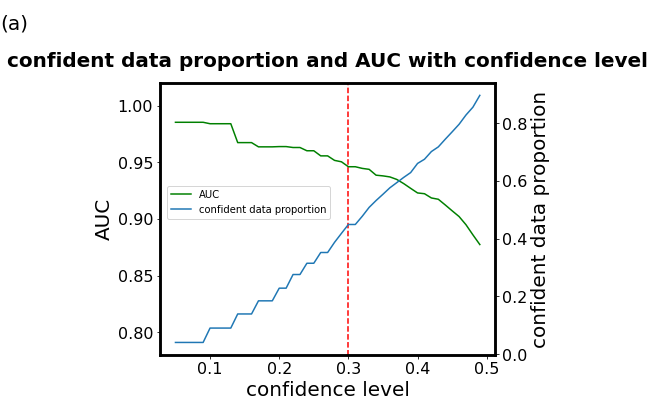

In [68]:
###plot the relation between BNN confident performance and confidence level,Fig6
a=np.array(confident_results)
#print(a[:,0],confidence_ratio)

x=[]
for i in range(45):
    x.append(0.01*i+0.05)

f, ax= plt.subplots(figsize = (6, 5))
p1=fig=plt.plot(x,np.array(confident_results)[:,1],label="AUC",color="green")
ax.set_title('confident data proportion and AUC with confidence level',fontsize=20,pad=16,fontweight="bold")
ax.set_xlabel("confidence level",fontsize=20)
ax.set_ylabel("AUC",fontsize=20)
ax.set_yticks([0.8,0.85,0.9,0.95,1.0])
ax.set_ylim([0.78, 1.02])
ax.tick_params(labelsize=16) 

ax.vlines(0.3, 0, 1.05, colors = "r", linestyles = "dashed")

ax2 = ax.twinx()
p2= ax2.plot(x,confidence_ratio,label="confident data proportion")
#ax.grid()
ax2.set_ylabel("confident data proportion",fontsize=20)
ax2.tick_params(labelsize=16) 
#ax2.legend(loc=0)

p=p1+p2
labs = [l.get_label() for l in p]
ax.legend(p, labs,fontsize=10,loc=(0.02,0.5))


for spine in ax.spines.values():
    spine.set_linewidth(2.5)
for spine in ax2.spines.values():
    spine.set_linewidth(2.5)

#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)

#ax2.spines['top'].set_visible(False)
#ax2.spines['right'].set_visible(False)

ax.annotate('(a)', xy=(1, 1), xytext=(0, 1.05),xycoords="figure fraction",fontsize=20)

plt.savefig(r"D:\HKUST\Program\结肠癌分类器\终稿\论文图片精修\图片修改v2\Fig6.png",dpi=800,bbox_inches='tight',pad_inches=0.2)



In [44]:
np.array(confident_results)[25,1],confidence_ratio[25]

(0.9465882860192552, 0.46390829303241987)

In [43]:
confidence_level = 0.3

confident_results = [];
K=10
kf = KFold(n_splits=K)


for train,test in kf.split(X):
    # K-fold 
    X_train=X.loc[train, :]
    X_test=X.loc[test,:]
    y_train=y[train]
    y_test=y[test]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train).astype(np.float32)
    X_test = scaler.transform(X_test).astype(np.float32)

    result,y_pred = BNN_algo(X_train,X_test,y_train,y_test)

    uncertainty = np.std(y_pred, axis=1)
    y_pred_class = np.median(y_pred,axis=1)
    
    is_confident = uncertainty <= confidence_level
    not_confident = uncertainty > confidence_level
    ratio = sum(is_confident)/len(uncertainty)
    
    result = show_result(y_test,y_pred_class)
    conf_result = show_result(y_test[is_confident],y_pred_class[is_confident])
    unco_result = show_result(y_test[not_confident],y_pred_class[not_confident])
    
    confident_results.append(conf_result)

s=pd.DataFrame(confident_results)
s.to_excel(r"D:\HKUST\Program\结肠癌分类器\终稿\3. results\confident patients\confident_vs_all.xlsx")

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [83]:
np.std([0.81,0.82,0.81])

0.004714045207910268

### Confident Data ROC

In [69]:
## 计算simplified data ROC
y = np.array(simplified_merged['癌'])
X = simplified_merged.drop(['癌'], axis=1)
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state= 42)
original_x_test=X_test.copy()
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_test = scaler.transform(X_test).astype(np.float32)

result,y_pred_class_simplified_BNN = BNN_algo(X_train,X_test,y_train,y_test)

uncertainty = np.std(y_pred_class_simplified_BNN, axis=1)
y_pred_class = np.median(y_pred_class_simplified_BNN,axis=1)
    
is_confident = uncertainty <= confidence_level
not_confident = uncertainty > confidence_level
ratio = sum(is_confident)/len(uncertainty)
    
conf_result,y_pred_class_simplified_confident_BNN = BNN_algo(X_train,X_test[is_confident],y_train,y_test[is_confident])

fpr_3, tpr_3, thresholds = metrics.roc_curve(y_test, y_pred_class_simplified_BNN.mean(1)) #simplified BNN
fpr_4, tpr_4, thresholds = metrics.roc_curve(y_test[is_confident], y_pred_class_simplified_confident_BNN.mean(1)) #confident simplified BNN

## 计算full data ROC
y = np.array(df['癌'])
X = df.drop(['癌'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state= 42)
original_x_test=X_test.copy()
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_test = scaler.transform(X_test).astype(np.float32)

result,y_pred_class_BNN = BNN_algo(X_train,X_test,y_train,y_test)

uncertainty = np.std(y_pred_class_BNN, axis=1)
y_pred_class = np.median(y_pred_class_BNN,axis=1)
    
is_confident = uncertainty <= confidence_level
not_confident = uncertainty > confidence_level
ratio = sum(is_confident)/len(uncertainty)
    
conf_result,y_pred_class_confident_BNN = BNN_algo(X_train,X_test[is_confident],y_train,y_test[is_confident])

fpr_1, tpr_1, thresholds = metrics.roc_curve(y_test, y_pred_class_BNN.mean(1)) #BNN
fpr_2, tpr_2, thresholds = metrics.roc_curve(y_test[is_confident], y_pred_class_confident_BNN.mean(1)) #confident BNN




  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

  0%|          | 0/2001 [00:00<?, ?it/s]

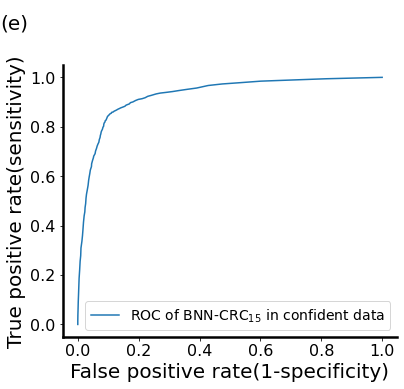

In [71]:
#fig8A

f, ax= plt.subplots(figsize = (6, 5))
#fig=plt.plot(fpr_1,tpr_1,label="ROC of BNN")
#fig=plt.plot(fpr_2,tpr_2,label="ROC of BNN in confident data")
#fig=plt.plot(fpr_3,tpr_3,label="ROC of simplified BNN")
fig=plt.plot(fpr_4,tpr_4,label="ROC of BNN-CRC$_{15}$ in confident data")

# 设置Axes的标题
#ax.set_title('ROC curve comparison in confident data')
ax.set_xlabel("False positive rate(1-specificity)",fontsize=20)
ax.set_ylabel("True positive rate(sensitivity)",fontsize=20)
ax.tick_params(labelsize=16) 
ax.legend(fontsize=14)

for spine in ax.spines.values():
    spine.set_linewidth(2.5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.annotate('(e)', xy=(1, 1), xytext=(0, 1),xycoords="figure fraction",fontsize=20)

plt.savefig(r"D:\HKUST\Program\结肠癌分类器\终稿\论文图片精修\图片修改v2\Fig8A.png",dpi=800,bbox_inches='tight',pad_inches=0.2)

In [ ]:
###比较BNN，XGB和Logistics的confident data

def calculate_uncertainty(prob_pos):
    uncertainty = [];
    for i in range(len(prob_pos)):
        ones = int(prob_pos[i]*100)
        zeros = 100 - ones 
        a = np.zeros(zeros)
        b = np.ones(ones)
        uncertainty.append(np.std(np.concatenate([a,b])))
    return np.array(uncertainty)


result,y_pred = XGboostAlgo(X_train,X_test,y_train,y_test)
#result,y_pred = LogisticAlgo(X_train,X_test,y_train,y_test)


uncertainty = calculate_uncertainty(y_pred[:,0])
y_pred_class = np.around(y_pred[:,1])

confidence_level = 0.45
is_confident = uncertainty <= confidence_level
not_confident = uncertainty > confidence_level
ratio = sum(is_confident)/len(uncertainty)
    
result = show_result(y_test,y_pred_class)
conf_result = show_result(y_test[is_confident],y_pred_class[is_confident])

In [230]:
print('test_acc using softmax and average:',np.sum((y_pred_class[not_confident] - y_test[not_confident]) == 0)/sum(not_confident))

test_acc using softmax and average: 0.7072425828970331


In [231]:
fpr, tpr, thresholds = metrics.roc_curve(y_test[is_confident], y_pred_class[is_confident])
metrics.auc(fpr, tpr)

0.9239554048440232

In [232]:
metrics.confusion_matrix(y_test[is_confident], y_pred_class[is_confident])

array([[2341,   44],
       [  87,  564]], dtype=int64)

In [525]:
metrics.confusion_matrix(y_test, y_pred_class)

array([[3324,  221],
       [ 673, 1365]], dtype=int64)

In [513]:
df.corr()["P-LCR"].loc["MPV"]

0.9632193221243083

In [72]:
import shap

In [62]:
def Blackbox_prediction(X):
    predictive= Predictive(model, guide=guide, num_samples=num_samples)
    preds = predictive(torch.from_numpy(X).float())
    
    y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
    y_std = preds['obs'].T.detach().numpy().std(axis=1)
    #return y_pred, y_std, y_pred_train, y_std_train
    return y_pred

In [238]:
explainer = shap.KernelExplainer(Blackbox_prediction,shap.sample(X_test,3000))
explainer.expected_value

Using 3000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


0.33261386138613863

In [239]:
explainer = shap.KernelExplainer(Blackbox_prediction,shap.sample(X_test,3000))
shap_values = explainer.shap_values(X_test[0:200], nsamples=150)

# plot the SHAP values for the Setosa output of the first instance
#shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:], link="logit")

Using 3000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/200 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

In [73]:
shap_values = pd.read_excel("D:\HKUST\Program\结肠癌分类器\终稿\去粪指标修改\supplementary files\SHAP\shape_value.xlsx",index_col=0)
shap_values = np.array(shap_values)

In [74]:
X_test = pd.read_excel(r"D:\HKUST\Program\结肠癌分类器\终稿\去粪指标修改\supplementary files\confident data\test_data.xlsx",index_col=0)
X_test.drop("癌",axis=1,inplace=True)
X_test = np.array(X_test)

In [75]:
np.shape(shap_values)

(200, 54)

In [76]:
shap_matrix=pd.DataFrame(shap_values)
shap_matrix.columns=df.iloc[:,0:-1].columns
shap_matrix

,Age,WBC,Lym,Mon,Ne,Eos,Baso,Lym%,Mon%,Eos%,Baso%,Ne%,RBC,Hb,HCT,MCV,MCH,MCHC,RDW,PLT,MPV,PCT,PDW,P-LCR,Urea,Na+,K+,Cl-,Glu,Creatinine,CO₂CP,Uric Acid,CA19-9,TBIL,DBIL,TP,ALB,Globulin,A/G,ALT,AST,ALP,TBA,γ-GT,Prealbumin,LDH,IBIL,CEA,FIT positive,FIT's data is missing',Fecal transferrin positive,Fecal transferrin's data is missing',Gender,BMI
0,0.023034,0.020877,0.015368,0.010369,-0.037514,0.000000,0.011582,0.000000,0.000000,0.000000,-0.000632,-0.022648,0.011342,-0.007926,0.019005,0.000000,0.019898,0.000000,-0.107190,0.000000,0.094539,0.000000,-0.007223,-0.172934,-0.009372,0.029580,-0.038102,-0.005242,0.019635,0.015049,0.010210,-0.057922,0.000000,0.018443,0.000000,0.049399,0.010099,0.016213,-0.074882,0.004470,0.000000,-0.005337,0.000000,0.000000,0.001180,0.011219,0.024498,0.000000,-0.039895,0.043747,-0.021922,0.096144,0.000000,-0.017390
1,-0.053665,0.000000,-0.008788,-0.001842,0.000000,-0.000513,-0.001094,0.000000,0.000000,-0.014469,0.000000,0.000000,-0.005880,0.000000,-0.001079,-0.001941,0.000000,0.000000,-0.072851,-0.004738,-0.002899,0.000000,0.000000,0.010745,0.007799,0.000000,-0.034139,-0.014390,-0.015296,-0.000266,-0.010876,0.000000,0.000000,0.000000,0.000000,-0.006198,0.000000,0.000000,0.005722,0.008185,0.000000,-0.010415,0.000000,0.000000,-0.022841,0.000000,0.000000,0.000000,-0.054855,-0.041800,0.000000,0.030041,-0.009116,0.000000
2,0.000000,0.004117,0.000000,0.000000,0.000000,0.002895,0.026640,0.000000,0.000000,0.015712,0.002305,0.019472,0.000000,0.020025,0.004749,-0.004187,0.013342,0.000000,0.193423,0.007029,-0.052509,0.017255,0.015531,0.072874,-0.015727,0.000000,0.030768,-0.017191,0.000000,0.037665,0.000000,-0.009139,0.024724,0.000000,0.005294,0.000000,0.010099,-0.024447,-0.027363,0.012715,0.002237,0.010939,-0.010637,0.000006,0.029485,0.011217,0.014358,0.000000,0.102102,0.024745,0.000000,0.082219,0.000000,0.000000
3,0.009172,0.000000,0.011014,0.000000,0.000000,-0.014872,0.000000,0.000000,-0.024535,-0.009176,0.000000,0.000000,-0.013254,0.000000,0.000000,-0.004499,0.000000,0.000000,-0.122698,0.000000,-0.006818,-0.000819,-0.011466,0.009014,0.016752,-0.005162,0.019616,-0.008505,0.000000,0.000000,0.000000,0.000000,-0.007338,0.000000,-0.007507,0.006301,-0.053381,0.000000,0.043595,-0.000958,0.000000,0.000000,0.014661,0.000000,0.000060,0.000000,-0.001442,0.000000,-0.078417,-0.072695,-0.017447,0.050068,-0.017019,0.000000
4,0.022028,-0.005747,0.003893,0.000000,0.000000,0.000000,0.000000,-0.009321,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.001510,0.000000,-0.007242,-0.038188,-0.012444,-0.008008,0.000000,-0.001091,0.008791,0.000000,0.000000,-0.012446,0.000000,0.000000,-0.009379,0.000000,0.000000,0.000000,0.000000,-0.008490,0.000000,-0.017045,0.000000,0.016629,0.000000,-0.016269,0.000000,0.019702,0.000000,-0.073737,0.011087,-0.019599,0.008483,-0.075604,-0.101459,-0.017595,0.089814,-0.033106,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,-0.049708,0.000000,0.000000,-0.001580,0.000000,0.000000,0.000000,-0.001391,0.008097,-0.006492,0.000000,-0.005701,-0.017938,0.008328,-0.000031,-0.004331,0.000000,-0.003426,-0.011491,-0.014586,-0.011563,-0.005047,0.007823,0.029715,-0.002389,-0.011126,-0.016904,-0.014371,0.004974,0.000000,0.011151,0.000000,0.000000,-0.011144,0.000000,-0.006339,0.004144,0.002619,-0.002958,0.000000,0.012079,0.000242,-0.033156,0.014826,-0.037319,0.005569,-0.014970,-0.006557,-0.060711,0.041351,-0.023297,-0.081284,0.024676,0.002259
196,0.000000,0.010512,-0.021571,0.003661,-0.002772,0.000898,0.006231,0.004662,0.008506,0.007237,0.000000,-0.003804,-0.008192,-0.006882,0.001363,-0.001971,0.000000,0.000000,-0.043584,-0.011712,-0.023187,-0.023896,-0.004584,0.024171,-0.022100,0.000000,-0.015264,0.017272,0.006916,-0.010010,0.017864,0.008383,0.000000,-0.018801,0.000000,0.000000,-0.034115,0.000000,0.006547,0.005088,0.006427,-0.0

In [144]:
xx=pd.DataFrame(shap_values,columns=df.iloc[:,0:-1].columns)
xx["MPV"]/sign["MPV"].sum()

0     -0.004727
1      0.000145
2      0.002625
3      0.000341
4      0.000400
         ...   
195    0.000578
196    0.001159
197    0.000754
198    0.000326
199   -0.001647
Name: MPV, Length: 200, dtype: float64

In [77]:
shap_matrix=pd.DataFrame(shap_values)
shap_matrix.columns=df.iloc[:,0:-1].columns

explained_data=pd.DataFrame(X_test[0:200])
explained_data.columns=df.iloc[:,0:-1].columns
sign = explained_data.copy()
for i in tqdm(explained_data.columns):
    for j in explained_data.index:
        if explained_data[i].loc[j]>=0:
            sign[i].loc[j] = 1
        else:
            sign[i].loc[j] = -1


shap_effect=shap_matrix/sign
shap_effect=pd.DataFrame(shap_effect.mean()).T

shap_effect=shap_effect.sort_values(axis=1,by=0,ascending=False)
shap_effect

shap_matrix=abs(shap_effect)
shap_matrix=shap_matrix.sort_values(axis=1,by=0,ascending=False)
shap_matrix=shap_matrix/float(shap_matrix.sum(1))
shap_matrix.sum()

  0%|          | 0/54 [00:00<?, ?it/s]

RDW                                     0.145356
FIT positive                            0.106984
Fecal transferrin's data is missing'    0.097808
FIT's data is missing'                  0.081115
Prealbumin                              0.053467
P-LCR                                   0.046758
Age                                     0.038076
MPV                                     0.028027
K+                                      0.025189
A/G                                     0.023857
TBA                                     0.021937
Fecal transferrin positive              0.020969
ALB                                     0.020919
RBC                                     0.017350
Eos%                                    0.016937
TP                                      0.016887
Gender                                  0.016356
Mon%                                    0.015297
Na+                                     0.013019
WBC                                     0.012719
PCT                 

In [78]:
explained_data

,Age,WBC,Lym,Mon,Ne,Eos,Baso,Lym%,Mon%,Eos%,Baso%,Ne%,RBC,Hb,HCT,MCV,MCH,MCHC,RDW,PLT,MPV,PCT,PDW,P-LCR,Urea,Na+,K+,Cl-,Glu,Creatinine,CO₂CP,Uric Acid,CA19-9,TBIL,DBIL,TP,ALB,Globulin,A/G,ALT,AST,ALP,TBA,γ-GT,Prealbumin,LDH,IBIL,CEA,FIT positive,FIT's data is missing',Fecal transferrin positive,Fecal transferrin's data is missing',Gender,BMI
0,-0.321170,-0.751142,-0.231292,-0.787063,-0.997882,-0.718385,-0.856183,1.215407,0.231042,-0.693820,-0.410655,-1.010666,-0.262418,0.251758,-5.160348,0.493591,0.780067,0.801736,-0.487350,-0.739815,2.712691,0.076330,3.594583,2.784773,-0.395632,-0.603745,-0.711534,0.808292,0.005918,-0.678927,1.215428,9.269355,0.003320,0.045179,-0.052700,1.198161,-0.336224,2.045328,-1.588859,-0.060339,-0.279996,0.108339,-0.161546,-0.409657,-0.178580,-0.588454,0.194779,-0.134483,-0.601909,-0.696752,-0.439016,1.048092,-0.002358,-0.018734
1,-1.576188,1.012154,0.640460,0.539700,1.444866,-0.718385,0.255118,-0.645239,-0.687320,-0.910530,-0.410655,0.933666,0.305589,-0.375245,-0.045214,-0.966759,-1.019702,-0.562704,-0.636661,1.144530,-0.313353,0.977817,-1.247171,-0.482917,-1.021377,-0.265464,0.364480,0.808292,-0.671045,-0.072289,-1.757016,-0.110424,0.003320,-0.060668,0.031457,-0.154796,0.041443,-0.399199,0.364982,-0.422594,-0.383139,-0.724322,-0.379268,-0.438452,-0.037807,-0.341255,-0.886306,-0.001143,-0.601909,1.435231,-0.439016,1.048092,-1.385353,0.039417
2,1.012286,-0.384147,0.063979,0.221277,-0.691378,0.516217,0.255118,0.595192,0.919814,0.953176,0.616307,-0.950709,-1.481963,-1.420249,-0.795076,0.553812,-0.011832,-0.903813,1.379048,-0.998153,-1.826375,-1.426148,0.674746,-1.628184,0.085711,-0.265464,0.364480,-2.205950,-0.117167,-0.615070,0.026450,-0.111886,0.290024,-0.290004,-0.192962,0.747176,-0.336224,1.378639,-1.227037,-0.567496,-0.245616,-0.245985,-0.246742,-0.438452,-0.896524,0.270859,-0.336280,-0.057929,1.661381,-0.696752,-0.439016,1.048092,-1.385353,-0.018358
3,0.071023,-0.751142,-1.384255,-1.423909,-0.556702,-0.780115,-0.856183,-0.823786,-0.993441,-0.823846,-0.410655,1.147799,0.689829,0.460758,0.477012,-0.349498,-0.299795,-0.016928,-0.636661,-0.572655,-0.086400,-0.524661,-0.766692,-0.209734,-0.973242,0.072818,0.364480,0.473376,0.313628,-0.710855,0.026450,-0.114226,-0.324234,-0.122413,-0.347251,0.596847,1.174444,-0.621429,1.450450,-0.024114,0.063811,-0.175120,-0.303539,-0.294478,-0.868369,0.576916,0.232712,-0.063073,-0.601909,1.435231,-0.439016,1.048092,-1.385353,-0.038652
4,0.698532,-0.567644,0.303008,-1.052416,-0.891070,-0.286274,-0.300532,1.450337,-0.649055,-0.043690,0.273987,-1.173408,-0.045239,-0.479745,-0.005042,-0.244111,-0.731739,-1.108479,-0.338038,1.949936,-0.464655,1.729056,-1.210211,-0.724579,0.278248,-0.265464,-0.711534,-0.196456,0.129002,-0.742783,0.026450,-0.113349,0.003320,0.106923,-0.122831,0.296190,0.607943,-0.399199,0.762987,-0.567496,-0.279996,-0.068823,-0.417133,-0.409657,0.651983,-0.002814,0.422376,-0.001143,-0.601909,1.435231,-0.439016,1.048092,-1.385353,-0.015070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,-1.497750,-0.045823,1.146639,-0.044076,-0.403449,-0.409734,-0.300532,1.140229,-0.075079,-0.520452,-0.410655,-0.907882,0.623005,-0.375245,-0.018433,-1.388304,-1.379656,-0.630925,0.035242,0.430303,-0.994213,0.076330,0.748666,-0.840156,-0.251229,1.087663,0.095477,0.473376,-0.732587,0.055425,0.620939,-0.104281,0.003320,-0.519340,-0.249067,0.145861,-0.147391,0.267490,-0.394845,2.040739,0.476379,-0.192836,0.387492,0.267023,0.201508,-0.152912,-0.753541,-0.143949,-0.601909,-0.696752,-0.439016,-0.954115,0.803761,0.115126
196,-0.007416,-0.318202,0.767005,-0.256358,-0.751750,0.269297,-0.300532,1.346968,0.154512,0.519756,-0.410655,-1.353280,0.389119,0.408508,0.570745,0.418316,-0.011832,-0.630925,-0.188726,0.795015,-0.767260,0.527073,0.748666,-0.693057,1.000261,-0.603745,-0.442530,-0.866287,-0.486419,0.502421,1.809917,-

In [79]:
shap_matrix

,RDW,FIT positive,Fecal transferrin's data is missing',FIT's data is missing',Prealbumin,P-LCR,Age,MPV,K+,A/G,TBA,Fecal transferrin positive,ALB,RBC,Eos%,TP,Gender,Mon%,Na+,WBC,PCT,Urea,ALP,PLT,Hb,Cl-,CA19-9,Lym,CO₂CP,MCHC,MCV,Mon,AST,CEA,Creatinine,Ne,Baso,HCT,Globulin,Baso%,TBIL,DBIL,Ne%,Eos,Uric Acid,Glu,MCH,IBIL,LDH,BMI,Lym%,ALT,PDW,γ-GT
0,0.145356,0.106984,0.097808,0.081115,0.053467,0.046758,0.038076,0.028027,0.025189,0.023857,0.021937,0.020969,0.020919,0.01735,0.016937,0.016887,0.016356,0.015297,0.013019,0.012719,0.011828,0.011664,0.011423,0.009228,0.008527,0.007862,0.0077,0.006741,0.00668,0.006659,0.006649,0.006448,0.005997,0.005902,0.005596,0.005334,0.005325,0.005254,0.004825,0.00448,0.004474,0.004364,0.004351,0.003932,0.003702,0.003154,0.003125,0.002746,0.002219,0.001202,0.001138,0.000997,0.000958,0.000491


In [80]:
shap_effect

,RDW,FIT positive,Fecal transferrin's data is missing',Age,MPV,K+,A/G,Fecal transferrin positive,Eos%,TP,Gender,Mon%,ALP,CA19-9,CO₂CP,MCHC,MCV,AST,CEA,Ne,TBIL,DBIL,Ne%,Eos,Glu,MCH,IBIL,BMI,PDW,γ-GT,ALT,Lym%,LDH,Uric Acid,Baso%,Globulin,HCT,Baso,Creatinine,Mon,Lym,Cl-,Hb,PLT,Urea,PCT,WBC,Na+,RBC,ALB,TBA,P-LCR,Prealbumin,FIT's data is missing'
0,0.101632,0.074803,0.068387,0.026623,0.019596,0.017612,0.016681,0.014661,0.011842,0.011807,0.011436,0.010696,0.007987,0.005384,0.004671,0.004656,0.004649,0.004193,0.004126,0.00373,0.003128,0.003051,0.003043,0.002749,0.002205,0.002185,0.00192,0.00084,0.00067,0.000343,-0.000697,-0.000796,-0.001552,-0.002589,-0.003132,-0.003373,-0.003674,-0.003724,-0.003913,-0.004508,-0.004713,-0.005497,-0.005962,-0.006452,-0.008155,-0.00827,-0.008893,-0.009103,-0.012131,-0.014626,-0.015338,-0.032693,-0.037384,-0.056716


In [262]:
useful_item=list(shap_matrix.columns[0:20])

In [11]:
useful_item=['RDW',
 'FIT positive',
 "FIT's data is missing'",
 'Prealbumin',
 'P-LCR',
 'Age',
 'ALB',
 'K+',
 'TBA',
 'RBC',
 'Eos%',
 'Gender',
 'Mon%',
 'Na+',
 'WBC']

In [82]:
shap_matrix[useful_item]

,RDW,FIT positive,FIT's data is missing',Prealbumin,P-LCR,Age,ALB,K+,TBA,RBC,Eos%,Gender,Mon%,Na+,WBC
0,0.145356,0.106984,0.081115,0.053467,0.046758,0.038076,0.020919,0.025189,0.021937,0.01735,0.016937,0.016356,0.015297,0.013019,0.012719


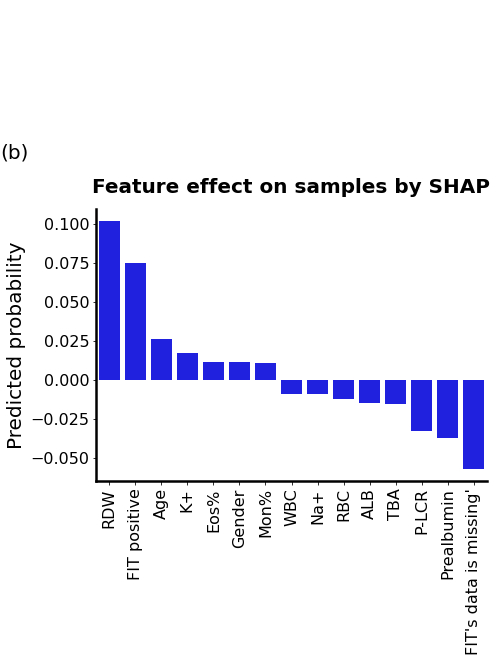

In [96]:
#Fig 11A
import seaborn as sns
important_features=list(shap_matrix.columns)#[0:20]
shap_effect=shap_effect[useful_item]
shap_effect.sort_values(axis=1,by=0,ascending=False,inplace=True)

f, ax= plt.subplots(figsize = (7, 5))
sns.barplot(data=shap_effect,color="blue");
plt.xticks(rotation=90,fontsize=16);
#ax.set_ylabel("Feature effect",fontsize=18)
ax.set_ylabel("Predicted probability",fontsize=20)
ax.tick_params(labelsize=16) 
plt.title("Feature effect on samples by SHAP",fontsize=20,pad=16,fontweight="bold")

for spine in ax.spines.values():
    spine.set_linewidth(2.5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.annotate('(b)', xy=(1, 1), xytext=(0, 1.4),xycoords="figure fraction",fontsize=20)

plt.savefig(r"D:\HKUST\Program\结肠癌分类器\终稿\论文图片精修\图片修改v2\Fig11A.png",dpi=800,bbox_inches='tight',pad_inches=0.2)

In [154]:
shap_matrix

,RDW,FIT positive,FIT's data is missing',Prealbumin,P-LCR,Age,K+,TBA,ALB,RBC,Eos%,Gender,Mon%,Na+,WBC
0,0.145356,0.106984,0.081115,0.053467,0.046758,0.038076,0.025189,0.021937,0.020919,0.01735,0.016937,0.016356,0.015297,0.013019,0.012719


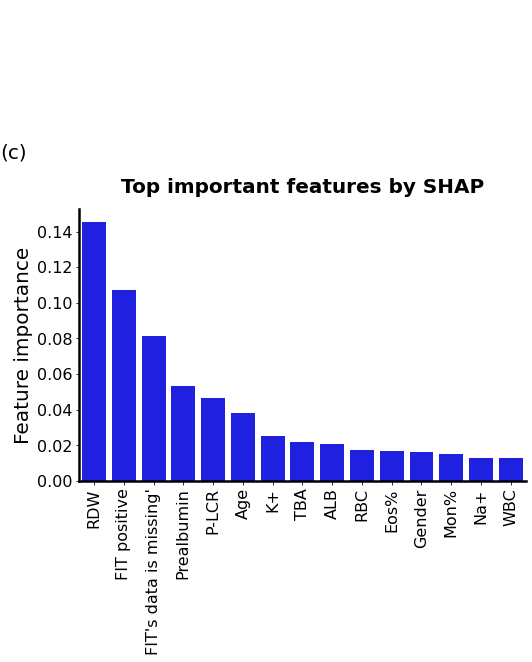

In [98]:
#Fig11B
import seaborn as sns
important_features=list(shap_matrix.columns)#[0:20]
shap_matrix=shap_matrix[useful_item]
shap_matrix.sort_values(axis=1,by=0,ascending=False,inplace=True)
f, ax= plt.subplots(figsize = (8, 5))

sns.barplot(data=shap_matrix,color="blue");
plt.xticks(rotation=90,fontsize=16);
plt.title("Top important features by SHAP",fontsize=20,pad=16,fontweight="bold")
ax.set_ylabel("Feature importance",fontsize=20)

ax.tick_params(labelsize=16) 

for spine in ax.spines.values():
    spine.set_linewidth(2.5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.annotate('(c)', xy=(1, 1), xytext=(0, 1.4),xycoords="figure fraction",fontsize=20)

plt.savefig(r"D:\HKUST\Program\结肠癌分类器\终稿\论文图片精修\图片修改v2\Fig11B.png",dpi=800,bbox_inches='tight',pad_inches=0.2)

In [162]:
shap_effect.to_excel(r"D:\HKUST\Program\结肠癌分类器\终稿\Ver 10.24\new_SHAP\All\feature_effect.xlsx")
shap_matrix.to_excel(r"D:\HKUST\Program\结肠癌分类器\终稿\Ver 10.24\new_SHAP\All\abs_importance.xlsx")
shap_effect[useful_item].to_excel(r"D:\HKUST\Program\结肠癌分类器\终稿\Ver 10.24\new_SHAP\21 simplified\feature_effect.xlsx")
shap_matrix[useful_item].to_excel(r"D:\HKUST\Program\结肠癌分类器\终稿\Ver 10.24\new_SHAP\21 simplified\abs_importance.xlsx")

In [270]:
shap_effect.to_excel(r"D:\HKUST\Program\结肠癌分类器\终稿\去粪指标修改\supplementary files\SHAP\feature_effect.xlsx")
shap_matrix.to_excel(r"D:\HKUST\Program\结肠癌分类器\终稿\去粪指标修改\supplementary files\SHAP\abs_importance.xlsx")
pd.DataFrame(shap_values).to_excel(r"D:\HKUST\Program\结肠癌分类器\终稿\去粪指标修改\supplementary files\SHAP\shape_value.xlsx")

In [8]:
useful_item=['RDW',
 'FIT positive',
 "Fecal transferrin's data is missing'",
 "FIT's data is missing'",
 'Prealbumin',
 'P-LCR',
 'Age',
 'MPV',
 'K+',
 'A/G',
 'TBA',
 'Fecal transferrin positive',
 'ALB',
 'RBC',
 'Eos%',
 'TP',
 'Gender',
 'Mon%',
 'Na+',
 'WBC']

In [42]:
s=abs(shap_effect)
s=s.sort_values(axis=1,by=0,ascending=False)
useful_item=list(s.iloc[:,0:20].columns)
simplified_merged=df.copy()
for i in simplified_merged.iloc[:,1:-5].columns:
    if i not in useful_item:
        simplified_merged=simplified_merged.drop(i,axis=1)


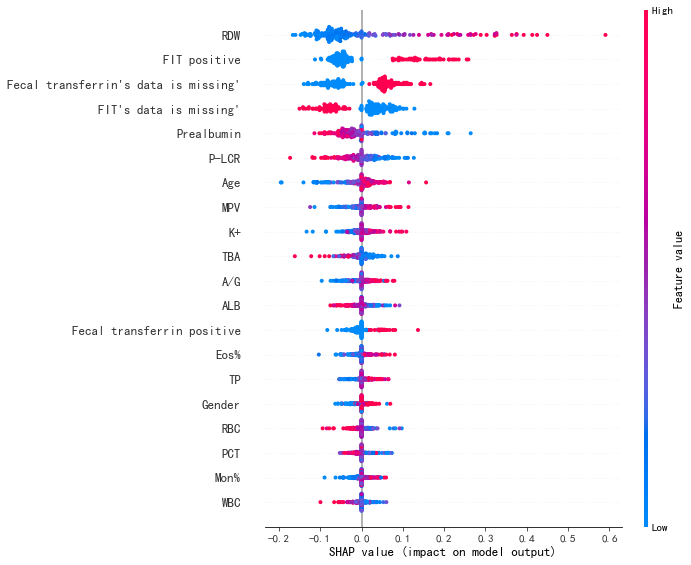

In [90]:
rc = {'font.sans-serif': 'SimHei','axes.unicode_minus': False}

plt.rcParams['font.sans-serif']=['SimHei'] #显示中文标签
plt.rcParams['axes.unicode_minus']=False

#shap.summary_plot(np.array(s),np.array(test_data),feature_names=columns_name,max_display=21)
shap.summary_plot(shap_values,X_test[0:200],feature_names=list(df.iloc[:,0:-1].columns),max_display=20)

In [497]:
list1=list(df.iloc[:,0:-1].columns)
list1[21]="Na+"

In [32]:
simplified_merged[simplified_merged["Gender"]==0]["Gender"].count()/27911

0.3306223352799971

In [45]:
a=simplified_merged[simplified_merged["癌"]==0]
b=a[a["Gender"]==1]
b

,Age,WBC,Mon%,Eos%,RBC,RDW,MPV,P-LCR,Na+,K+,TP,ALB,TBA,TBA,Prealbumin,FIT positive,FIT's data is missing',Fecal transferrin positive,Fecal transferrin's data is missing',Gender,癌
0,61,4.16,12.5,0.0,5.08,13.6,9.5,21.9,141.000000,4.500000,69.0,39.000000,1.30000,5.100000,147.00000,0,1,0,1,1.0,0
1,73,3.63,4.7,1.1,4.81,12.9,10.4,28.0,142.000000,4.000000,72.0,47.000000,1.88000,6.500000,192.00000,0,1,0,1,1.0,0
5,58,5.13,7.4,4.5,4.70,13.2,10.8,32.2,146.000000,4.200000,67.0,39.000000,1.39000,5.000000,248.00000,0,0,0,1,1.0,0
6,68,5.83,6.3,1.7,2.94,15.3,11.8,38.7,144.000000,4.400000,58.0,40.000000,2.22000,5.500000,299.00000,0,1,0,1,1.0,0
9,72,5.43,4.2,2.0,4.38,14.4,11.0,31.9,141.780249,4.062808,68.0,41.797448,1.51984,5.534524,225.49881,0,1,0,1,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27900,59,6.79,8.7,3.4,4.15,15.8,11.6,38.2,142.000000,4.000000,63.0,41.000000,1.86000,7.600000,193.00000,0,0,0,0,1.0,0
27902,65,4.11,7.3,6.3,4.65,12.4,12.4,45.1,141.000000,3.700000,71.0,45.000000,1.73000,4.600000,237.00000,0,1,0,1,1.0,0
27903,56,5.23,8.6,3.4,4.89,12.2,11.2,36.3,142.000000,3.800000,73.0,46.000000,1.70000,7.800000,254.00000,0,0,0,0,1.0,0
27906,56,5.51,8.2,3.1,4.24,12.0,10.5,28.6,143.000000,4.100000,62.0,37.000000,1.48000,2.800000,257.00000,0,1,0,1,1.0,0


,Age,WBC,Mon%,Eos%,RBC,RDW,MPV,P-LCR,Na+,K+,TP,ALB,TBA,TBA,Prealbumin,FIT positive,FIT's data is missing',Fecal transferrin positive,Fecal transferrin's data is missing',Gender,癌
0,61,4.16,12.5,0.0,5.08,13.6,9.5,21.9,141.0,4.5,69.0,39.0,1.30,5.1,147.00000,0,1,0,1,1.00000,0
1,73,3.63,4.7,1.1,4.81,12.9,10.4,28.0,142.0,4.0,72.0,47.0,1.88,6.5,192.00000,0,1,0,1,1.00000,0
2,84,3.65,6.0,2.7,3.68,12.8,9.2,17.6,136.0,4.2,70.0,43.0,1.59,2.2,210.00000,0,1,0,1,0.00000,0
3,71,7.29,4.1,1.6,3.84,12.4,9.6,21.6,146.0,4.1,74.0,45.0,1.55,10.1,225.49881,0,1,0,1,0.63176,0
4,80,5.68,6.5,2.1,3.06,11.6,9.2,17.7,132.0,3.8,63.0,37.0,1.42,2.3,199.00000,0,1,0,1,0.00000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27903,56,5.23,8.6,3.4,4.89,12.2,11.2,36.3,142.0,3.8,73.0,46.0,1.70,7.8,254.00000,0,0,0,0,1.00000,0
27906,56,5.51,8.2,3.1,4.24,12.0,10.5,28.6,143.0,4.1,62.0,37.0,1.48,2.8,257.00000,0,1,0,1,1.00000,0
27907,76,5.71,6.1,0.5,3.93,12.0,10.2,25.5,143.0,4.3,62.0,36.0,1.38,2.3,228.00000,0,1,0,1,0.00000,0
27908,65,5.99,12.2,8.0,4.21,13.0,13.1,50.4,142.0,3.9,63.0,40.0,1.74,2.2,213.00000,0,1,0,1,1.00000,0


In [46]:
simplified_merged.corr()

,Age,WBC,Mon%,Eos%,RBC,RDW,MPV,P-LCR,Na+,K+,TP,ALB,TBA,TBA,Prealbumin,FIT positive,FIT's data is missing',Fecal transferrin positive,Fecal transferrin's data is missing',Gender,癌
Age,1.000000,-0.022566,0.063144,0.020083,-0.256515,0.073281,-0.035648,-0.038318,-0.027590,0.051190,-0.151148,-0.262541,-0.180635,0.030283,-0.225926,0.119089,-0.019845,0.089631,0.018239,-0.014231,0.193736
WBC,-0.022566,1.000000,-0.191694,-0.087951,0.089865,-0.071137,-0.020690,-0.011237,-0.060965,-0.000403,-0.026020,-0.058127,-0.065711,0.003279,-0.020411,-0.026832,0.030713,-0.003841,-0.001994,0.064951,-0.055728
Mon%,0.063144,-0.191694,1.000000,0.097176,-0.177088,0.239191,0.025701,0.015941,-0.083930,0.020611,-0.069159,-0.087062,-0.045248,0.059033,-0.122700,0.118533,-0.092545,0.076517,-0.045710,0.102572,0.204397
Eos%,0.020083,-0.087951,0.097176,1.000000,0.020620,-0.010404,-0.008508,-0.013632,0.030616,0.032159,-0.058474,-0.010831,0.014261,0.006175,0.012316,0.006380,-0.036552,0.006602,-0.043494,0.107731,0.039887
RBC,-0.256515,0.089865,-0.177088,0.020620,1.000000,-0.273985,0.048096,0.053297,0.110477,0.024274,0.266815,0.357395,0.201053,-0.046976,0.393757,-0.201555,0.078966,-0.154907,0.011615,0.320044,-0.309625
RDW,0.073281,-0.071137,0.239191,-0.010404,-0.273985,1.000000,-0.148579,-0.116042,-0.112377,0.070866,-0.052287,-0.175260,-0.151146,0.053922,-0.216132,0.272707,-0.075507,0.168714,0.053632,-0.057903,0.415655
MPV,-0.035648,-0.020690,0.025701,-0.008508,0.048096,-0.148579,1.000000,0.963219,0.091219,-0.061194,-0.049584,0.033946,0.088393,0.033137,-0.003598,-0.089960,-0.022786,-0.045108,-0.084643,-0.010311,-0.130575
P-LCR,-0.038318,-0.011237,0.015941,-0.013632,0.053297,-0.116042,0.963219,1.000000,0.089921,-0.066451,-0.052773,0.027042,0.082545,0.036824,-0.011264,-0.088442,-0.025406,-0.042158,-0.088860,-0.013357,-0.134394
Na+,-0.027590,-0.060965,-0.083930,0.030616,0.110477,-0.112377,0.091219,0.089921,1.000000,-0.082058,0.032552,0.152232,0.124775,-0.025452,0.184912,-0.097606,-0.049877,-0.090839,-0.067241,-0.037048,-0.177250
K+,0.051190,-0.000403,0.020611,0.032159,0.024274,0.070866,-0.061194,-0.066451,-0.082058,1.000000,0.108356,0.020173,-0.007395,-0.033593,0.013284,0.074227,0.064722,0.060383,0.089530,0.077229,0.120048


In [42]:
9806/(9806+5611)

0.6360511124083804

In [100]:
useful_item

['RDW',
 "Fecal transferrin's data is missing'",
 'FIT positive',
 "FIT's data is missing'",
 'Prealbumin',
 'P-LCR',
 'MCV',
 'ALB',
 'Age',
 'TBA',
 'A/G',
 'MPV',
 'K+',
 'TP',
 'Na+',
 'Eos',
 'CEA',
 'Eos%',
 'WBC',
 'Gender']

In [519]:
useful_item.remove('MPV')
useful_item.remove('A/G')
useful_item.remove('TP')
useful_item

['RDW',
 'FIT positive',
 "Fecal transferrin's data is missing'",
 "FIT's data is missing'",
 'Prealbumin',
 'P-LCR',
 'Age',
 'K+',
 'TBA',
 'Fecal transferrin positive',
 'ALB',
 'RBC',
 'Eos%',
 'Gender',
 'Mon%',
 'Na+',
 'WBC']

### Correlations


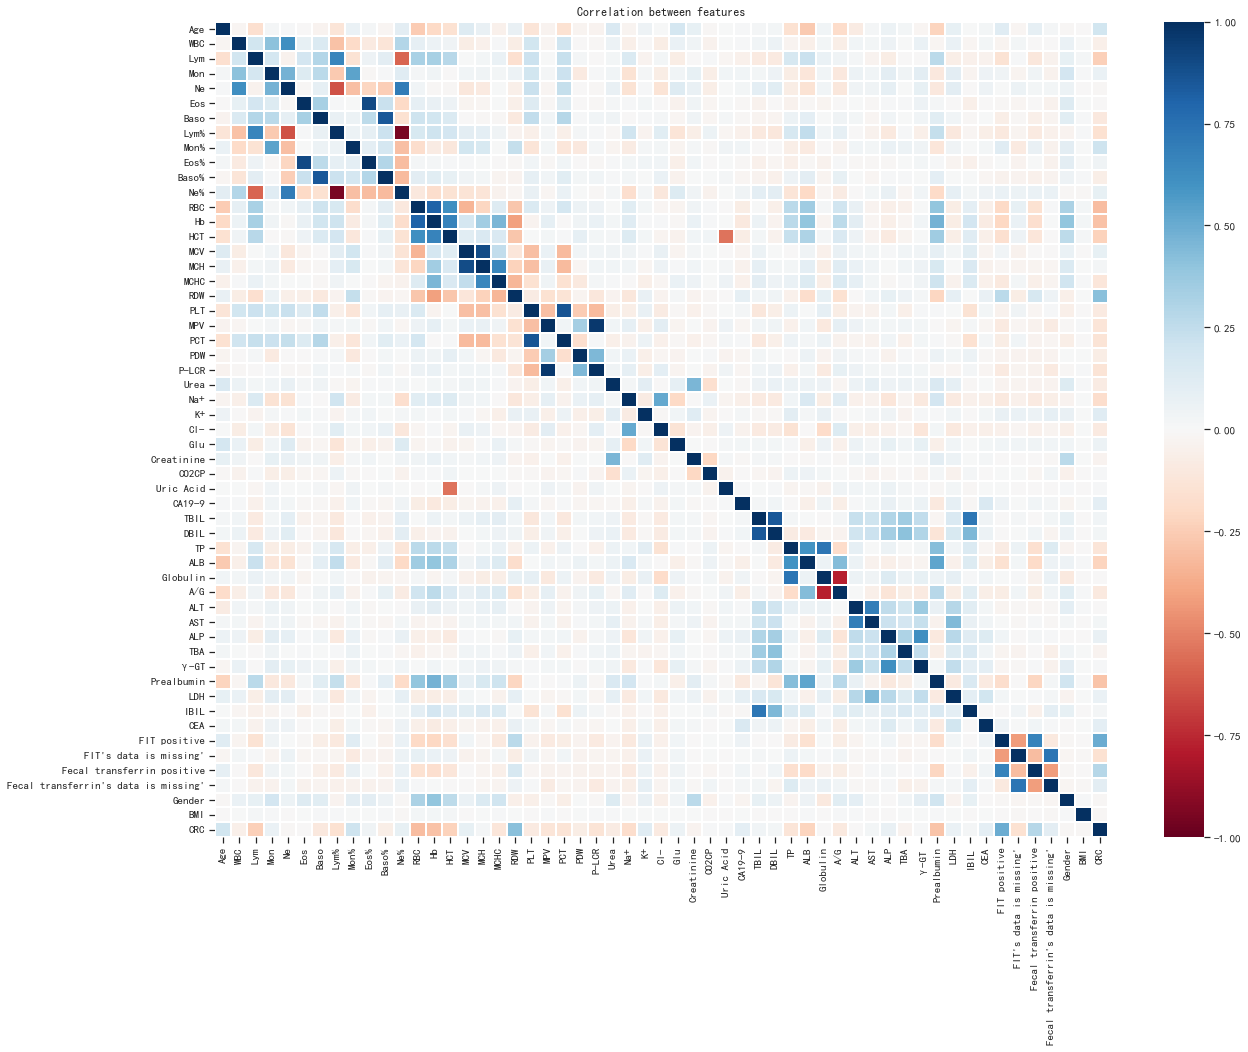

In [279]:
dff = df.copy()
dff.rename(columns={'癌':"CRC"},inplace=True)
corr = dff.corr()
# print(corr)
f, ax= plt.subplots(figsize = (20, 15))
rc = {'font.sans-serif': 'SimHei','axes.unicode_minus': False}
sns.set(context='notebook', style='ticks', rc=rc)
sns.heatmap(corr,cmap='RdBu', linewidths = 0.1,xticklabels=True, yticklabels=True, ax = ax, vmin=-1,vmax=1)
# 设置Axes的标题
ax.set_title('Correlation between features')
plt.show()

In [281]:
corr.to_excel(r"D:\HKUST\Program\结肠癌分类器\终稿\去粪指标修改\supplementary files\correlation\full_corr.xlsx")

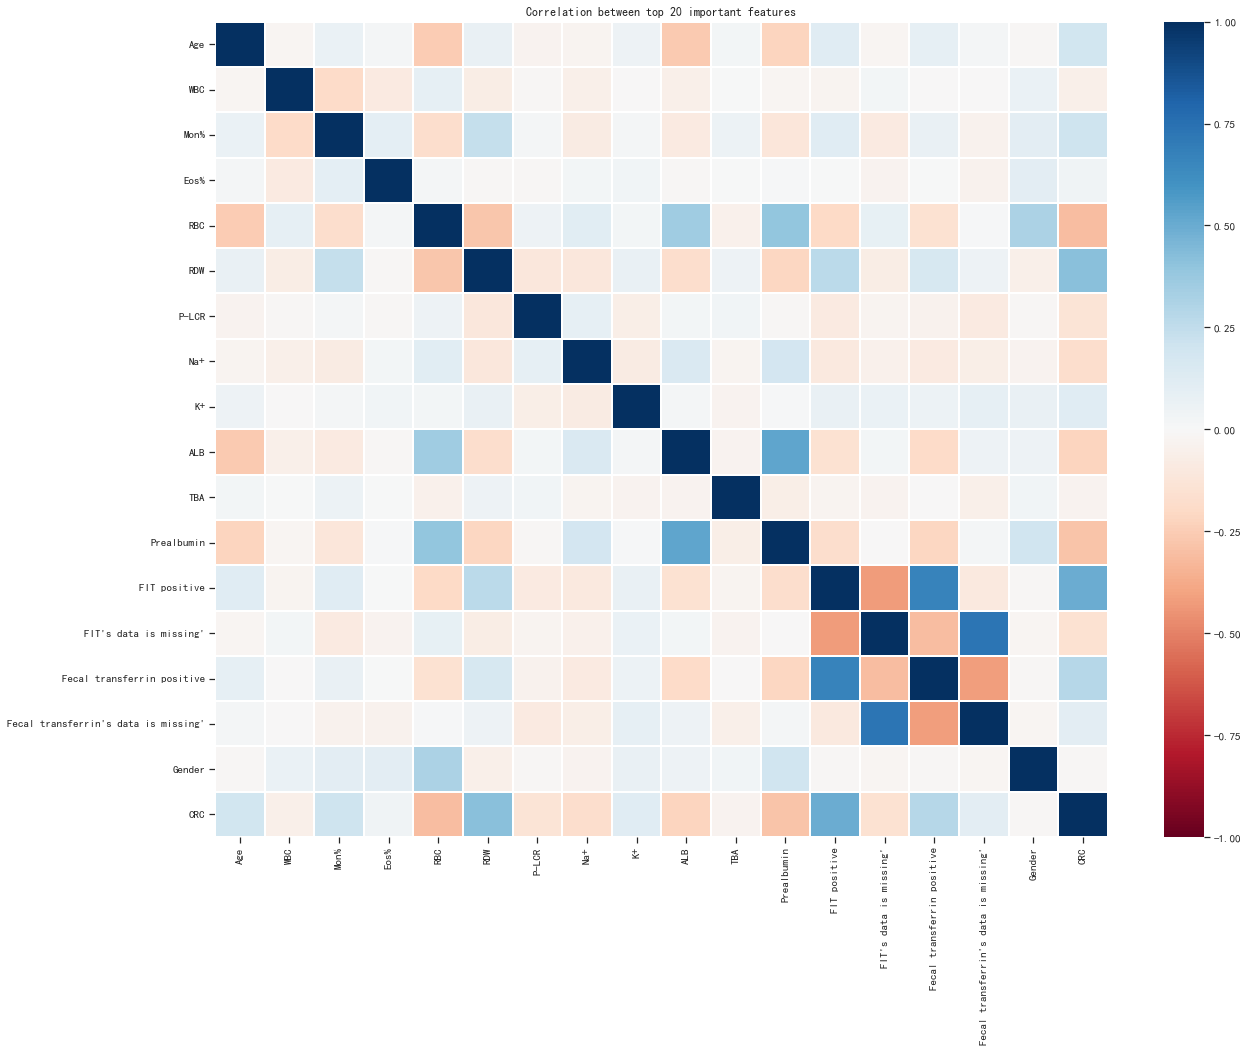

In [523]:
simplified_data = dff.copy()
for i in simplified_data.columns[:-1]:
    if i not in useful_item:
        simplified_data.drop(i,axis=1,inplace = True)
        
corr = simplified_data.corr()
# print(corr)
f, ax= plt.subplots(figsize = (20, 15))
rc = {'font.sans-serif': 'SimHei','axes.unicode_minus': False}
sns.set(context='notebook', style='ticks', rc=rc)
sns.heatmap(corr,cmap='RdBu', linewidths = 0.1,xticklabels=True, yticklabels=True, ax = ax, vmin=-1,vmax=1)
# 设置Axes的标题
ax.set_title('Correlation between top 20 important features')
plt.show()

#corr.to_excel(r"D:\HKUST\Program\结肠癌分类器\终稿\去粪指标修改\supplementary files\correlation\simplified_corr.xlsx")

In [108]:
simplified_merged.corr()

,Age,WBC,Mon%,Eos%,RBC,RDW,MPV,P-LCR,Na+,K+,TP,ALB,TBA,TBA,Prealbumin,FIT positive,FIT's data is missing',Fecal transferrin positive,Fecal transferrin's data is missing',Gender,癌
Age,1.000000,-0.022566,0.063144,0.020083,-0.256515,0.073281,-0.035648,-0.038318,-0.027590,0.051190,-0.151148,-0.262541,-0.180635,0.030283,-0.225926,0.119089,-0.019845,0.089631,0.018239,-0.014231,0.193736
WBC,-0.022566,1.000000,-0.191694,-0.087951,0.089865,-0.071137,-0.020690,-0.011237,-0.060965,-0.000403,-0.026020,-0.058127,-0.065711,0.003279,-0.020411,-0.026832,0.030713,-0.003841,-0.001994,0.064951,-0.055728
Mon%,0.063144,-0.191694,1.000000,0.097176,-0.177088,0.239191,0.025701,0.015941,-0.083930,0.020611,-0.069159,-0.087062,-0.045248,0.059033,-0.122700,0.118533,-0.092545,0.076517,-0.045710,0.102572,0.204397
Eos%,0.020083,-0.087951,0.097176,1.000000,0.020620,-0.010404,-0.008508,-0.013632,0.030616,0.032159,-0.058474,-0.010831,0.014261,0.006175,0.012316,0.006380,-0.036552,0.006602,-0.043494,0.107731,0.039887
RBC,-0.256515,0.089865,-0.177088,0.020620,1.000000,-0.273985,0.048096,0.053297,0.110477,0.024274,0.266815,0.357395,0.201053,-0.046976,0.393757,-0.201555,0.078966,-0.154907,0.011615,0.320044,-0.309625
RDW,0.073281,-0.071137,0.239191,-0.010404,-0.273985,1.000000,-0.148579,-0.116042,-0.112377,0.070866,-0.052287,-0.175260,-0.151146,0.053922,-0.216132,0.272707,-0.075507,0.168714,0.053632,-0.057903,0.415655
MPV,-0.035648,-0.020690,0.025701,-0.008508,0.048096,-0.148579,1.000000,0.963219,0.091219,-0.061194,-0.049584,0.033946,0.088393,0.033137,-0.003598,-0.089960,-0.022786,-0.045108,-0.084643,-0.010311,-0.130575
P-LCR,-0.038318,-0.011237,0.015941,-0.013632,0.053297,-0.116042,0.963219,1.000000,0.089921,-0.066451,-0.052773,0.027042,0.082545,0.036824,-0.011264,-0.088442,-0.025406,-0.042158,-0.088860,-0.013357,-0.134394
Na+,-0.027590,-0.060965,-0.083930,0.030616,0.110477,-0.112377,0.091219,0.089921,1.000000,-0.082058,0.032552,0.152232,0.124775,-0.025452,0.184912,-0.097606,-0.049877,-0.090839,-0.067241,-0.037048,-0.177250
K+,0.051190,-0.000403,0.020611,0.032159,0.024274,0.070866,-0.061194,-0.066451,-0.082058,1.000000,0.108356,0.020173,-0.007395,-0.033593,0.013284,0.074227,0.064722,0.060383,0.089530,0.077229,0.120048


In [48]:
simplified_data = df.copy()
for i in simplified_data.columns[:-1]:
    if i not in useful_item:
        simplified_data.drop(i,axis=1,inplace = True)
simplified_data

,Age,WBC,Mon%,Eos%,RBC,RDW,P-LCR,Na+,K+,ALB,TBA,Prealbumin,FIT positive,FIT's data is missing',Gender,癌
0,61,4.16,12.5,0.0,5.08,13.6,21.9,141.0,4.5,39.0,5.1,147.00000,0,1,1.00000,0
1,73,3.63,4.7,1.1,4.81,12.9,28.0,142.0,4.0,47.0,6.5,192.00000,0,1,1.00000,0
2,84,3.65,6.0,2.7,3.68,12.8,17.6,136.0,4.2,43.0,2.2,210.00000,0,1,0.00000,0
3,71,7.29,4.1,1.6,3.84,12.4,21.6,146.0,4.1,45.0,10.1,225.49881,0,1,0.63176,0
4,80,5.68,6.5,2.1,3.06,11.6,17.7,132.0,3.8,37.0,2.3,199.00000,0,1,0.00000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27906,56,5.51,8.2,3.1,4.24,12.0,28.6,143.0,4.1,37.0,2.8,257.00000,0,1,1.00000,0
27907,76,5.71,6.1,0.5,3.93,12.0,25.5,143.0,4.3,36.0,2.3,228.00000,0,1,0.00000,0
27908,65,5.99,12.2,8.0,4.21,13.0,50.4,142.0,3.9,40.0,2.2,213.00000,0,1,1.00000,0
27909,52,6.72,7.3,3.1,4.33,12.6,27.3,139.0,4.1,49.0,20.1,310.00000,0,0,0.00000,0


### Box plot


In [10]:
useful_item= ['RDW',
 'FIT positive',
 "FIT's data is missing'",
 'Prealbumin',
 'P-LCR',
 'Age',
 'ALB',
 'K+',
 'TBA',
 'RBC',
 'Eos%',
 'Gender',
 'Mon%',
 'Na+',
 'WBC']

In [11]:
simplified_data = df.copy()
for i in simplified_data.columns[:-1]:
    if i not in useful_item:
        simplified_data.drop(i,axis=1,inplace = True)
simplified_data

,Age,WBC,Mon%,Eos%,RBC,RDW,P-LCR,Na+,K+,ALB,TBA,Prealbumin,FIT positive,FIT's data is missing',Gender,癌
0,61,4.16,12.5,0.0,5.08,13.6,21.9,141.0,4.5,39.0,5.1,147.00000,0,1,1.00000,0
1,73,3.63,4.7,1.1,4.81,12.9,28.0,142.0,4.0,47.0,6.5,192.00000,0,1,1.00000,0
2,84,3.65,6.0,2.7,3.68,12.8,17.6,136.0,4.2,43.0,2.2,210.00000,0,1,0.00000,0
3,71,7.29,4.1,1.6,3.84,12.4,21.6,146.0,4.1,45.0,10.1,225.49881,0,1,0.63176,0
4,80,5.68,6.5,2.1,3.06,11.6,17.7,132.0,3.8,37.0,2.3,199.00000,0,1,0.00000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27906,56,5.51,8.2,3.1,4.24,12.0,28.6,143.0,4.1,37.0,2.8,257.00000,0,1,1.00000,0
27907,76,5.71,6.1,0.5,3.93,12.0,25.5,143.0,4.3,36.0,2.3,228.00000,0,1,0.00000,0
27908,65,5.99,12.2,8.0,4.21,13.0,50.4,142.0,3.9,40.0,2.2,213.00000,0,1,1.00000,0
27909,52,6.72,7.3,3.1,4.33,12.6,27.3,139.0,4.1,49.0,20.1,310.00000,0,0,0.00000,0


In [66]:
### Spilt simplified data
y = np.array(simplified_data['癌'])
#X = df.drop(['PATIENT_ID', '癌'], axis=1)
X = simplified_data.drop(['癌'], axis=1)
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state= 42)
original_x_test=X_test.copy()
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_test = scaler.transform(X_test).astype(np.float32)

  0%|          | 0/2001 [00:00<?, ?it/s]

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 1 1 ... 1 1 1]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 1 1 1]
 [0 0 0 ... 0 1 0]]


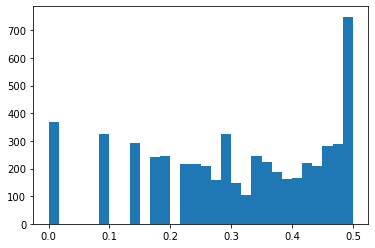

[0. 0. 1. ... 0. 1. 0.]
0.46534121440085974


In [67]:
model = Model(d_in=X_train.shape[1], h1=200, h2=None)
guide = AutoDiagonalNormal(model)
optim = pyro.optim.Adam({"lr": 0.01})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

pyro.clear_param_store()
bar = trange(2001)
x_torch = torch.from_numpy(X_train).float()
y_torch = torch.from_numpy(y_train).float()
for epoch in bar:
    loss = svi.step(x_torch, y_torch)
    bar.set_postfix(loss=f'{loss / X_train.shape[0]:.3f}')


num_samples = 101
predictive = Predictive(model, guide=guide, num_samples=num_samples)
preds = predictive(torch.from_numpy(X_test).float()) #对test数据
#preds = predictive(torch.from_numpy(X).float())

y_pred = preds['obs'].T.detach().numpy()
print(y_pred)

uncertainty = np.std(y_pred, axis=1)
plt.hist(uncertainty, bins=30)
plt.show()

y_pred_class = np.median(y_pred,axis=1)
y_pred_prob = np.mean(y_pred,axis=1)
print(y_pred_class)

is_confident = uncertainty < 0.3
print(sum(is_confident)/len(uncertainty))

In [68]:
original_test = original_x_test.copy()
original_test.insert(loc=len(original_test.columns),column="癌",value=y_test)
all_data=original_test.copy()
confident_data=original_test[is_confident].copy()

for i in all_data.columns[:-1]:
    if i not in useful_item:
        all_data.drop(i,axis=1,inplace=True)

for i in confident_data.columns[:-1]:
    if i not in useful_item:
        confident_data.drop(i,axis=1,inplace=True)

confident_data.iloc[:,:-6]
confident_data.iloc[:,-6:-2]

,TBA,Prealbumin,FIT positive,FIT's data is missing'
3834,3.9,213.0,0,0
26271,1.6,223.0,0,1
16443,3.0,162.0,1,0
9427,2.4,164.0,0,1
6316,1.2,272.0,0,1
...,...,...,...,...
23975,7.9,233.0,0,0
9240,1.1,188.0,0,1
408,5.9,274.0,0,1
15660,6.9,337.0,0,1


In [69]:
all_data

,Age,WBC,Mon%,Eos%,RBC,RDW,P-LCR,Na+,K+,ALB,TBA,Prealbumin,FIT positive,FIT's data is missing',Gender,癌
3834,53,3.79,7.9,0.8,4.21,12.6,54.8,140.0,3.8,40.0,3.9,213.0,0,0,0.63176,0
26271,37,9.94,5.5,0.3,4.55,12.2,23.7,141.0,4.2,42.0,1.6,223.0,0,1,0.00000,0
16443,70,5.07,9.7,4.6,3.48,17.6,12.8,141.0,4.2,40.0,3.0,162.0,1,0,0.00000,1
9427,58,3.79,4.7,0.5,4.78,12.2,26.3,142.0,4.2,48.0,2.4,164.0,0,1,0.00000,0
6316,66,4.43,5.6,2.3,4.34,13.0,21.4,141.0,3.8,45.0,1.2,272.0,0,1,0.00000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15660,31,7.06,4.7,1.1,5.35,13.0,33.7,139.0,4.4,47.0,6.9,337.0,0,1,0.63176,0
17907,56,4.79,8.0,2.6,3.90,14.3,16.7,143.0,4.1,46.0,9.5,234.0,0,0,0.00000,1
10128,71,4.82,4.8,1.0,4.13,12.8,26.0,145.0,3.7,38.0,12.1,172.0,0,0,0.00000,0
15533,80,6.15,7.0,1.9,4.44,13.2,16.4,143.0,4.6,45.0,4.6,226.0,1,0,1.00000,1


In [70]:
confident_data

,Age,WBC,Mon%,Eos%,RBC,RDW,P-LCR,Na+,K+,ALB,TBA,Prealbumin,FIT positive,FIT's data is missing',Gender,癌
3834,53,3.79,7.9,0.8,4.21,12.6,54.800000,140.000000,3.800000,40.0,3.9,213.0,0,0,0.63176,0
26271,37,9.94,5.5,0.3,4.55,12.2,23.700000,141.000000,4.200000,42.0,1.6,223.0,0,1,0.00000,0
16443,70,5.07,9.7,4.6,3.48,17.6,12.800000,141.000000,4.200000,40.0,3.0,162.0,1,0,0.00000,1
9427,58,3.79,4.7,0.5,4.78,12.2,26.300000,142.000000,4.200000,48.0,2.4,164.0,0,1,0.00000,0
6316,66,4.43,5.6,2.3,4.34,13.0,21.400000,141.000000,3.800000,45.0,1.2,272.0,0,1,0.00000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23975,44,7.05,8.9,0.7,5.29,12.1,31.100000,142.000000,3.600000,44.0,7.9,233.0,0,0,1.00000,0
9240,36,6.51,5.1,2.9,4.67,12.6,28.324203,141.780249,4.062808,46.0,1.1,188.0,0,1,0.63176,0
408,77,6.52,6.1,4.6,4.34,12.3,42.000000,146.000000,3.700000,41.0,5.9,274.0,0,1,0.00000,0
15660,31,7.06,4.7,1.1,5.35,13.0,33.700000,139.000000,4.400000,47.0,6.9,337.0,0,1,0.63176,0


In [113]:
unit = pd.read_excel(r"D:\HKUST\Program\结肠癌分类器\终稿\feature name and unit.xlsx")

In [126]:
useful_item

['RDW',
 'FIT positive',
 "FIT's data is missing'",
 'Prealbumin',
 'P-LCR',
 'Age',
 'ALB',
 'K+',
 'TBA',
 'RBC',
 'Eos%',
 'Gender',
 'Mon%',
 'Na+',
 'WBC']

In [129]:
nonbin_useful_item = useful_item.copy()
nonbin_useful_item.remove('FIT positive')
nonbin_useful_item.remove("FIT's data is missing'")
nonbin_useful_item.remove('Gender')

bin_useful_item = ['FIT positive',"FIT's data is missing'",'Gender']

In [131]:
anno_list_1 =  ["("+chr(i)+")" for i in range(ord('d'), ord('m')+1)]
anno_list_2 =  ["("+chr(i)+")" for i in range(ord('n'), ord('p')+1)]
print(anno_list_1,anno_list_2)


['(d)', '(e)', '(f)', '(g)', '(h)', '(i)', '(j)', '(k)', '(l)', '(m)'] ['(n)', '(o)', '(p)']


In [78]:
from scipy import stats

pvalue = pd.DataFrame()
for i in all_data.columns[:-1]:

    box_1, box_2 = all_data[all_data["癌"]==1][i], confident_data[confident_data["癌"]==1][i]
    box_3, box_4 = all_data[all_data["癌"]==0][i], confident_data[confident_data["癌"]==0][i]
    p = stats.ttest_ind(box_1,box_3 , equal_var= False)[1]
    p_conf = stats.ttest_ind(box_2,box_4 , equal_var= False)[1]
    
    p = "{:.3f}".format(float(p))
    p_conf = "{:.3f}".format(float(p_conf))
    
    pvalue.insert(loc=len(pvalue.columns),column=i,value=[p,p_conf])

In [81]:
pvalue
pvalue.to_excel(r"D:\HKUST\Program\结肠癌分类器\审稿\p_value.xlsx")

In [55]:
for i in all_data.columns[:-4]:

    box_1, box_2 = all_data[all_data["癌"]==1][i], confident_data[confident_data["癌"]==1][i]
    box_3, box_4 = all_data[all_data["癌"]==0][i], confident_data[confident_data["癌"]==0][i]

In [61]:
pvalue = pd.DataFrame()
pvalue.insert(loc=)

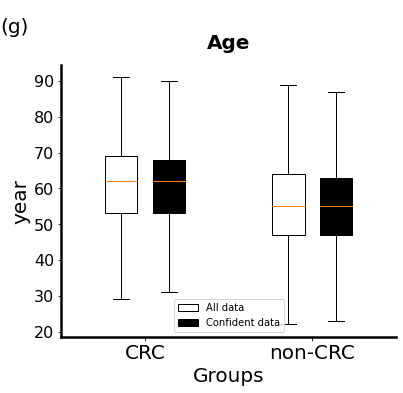

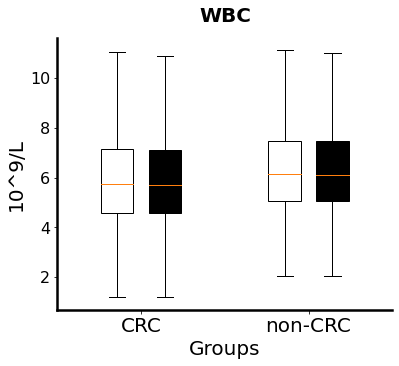

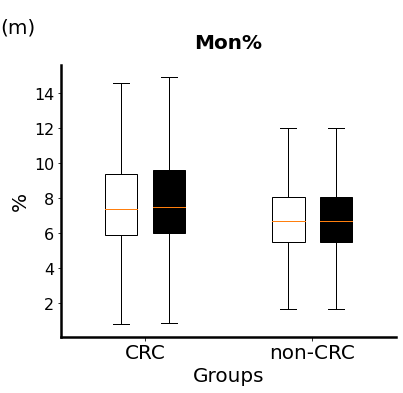

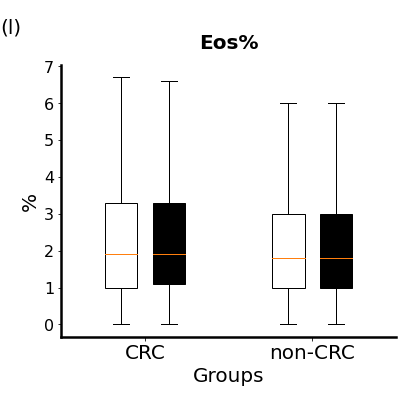

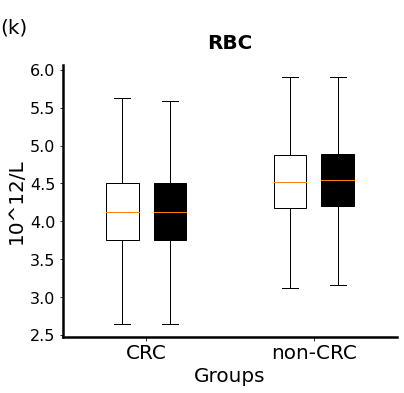

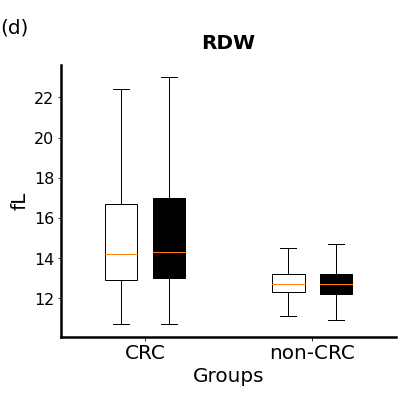

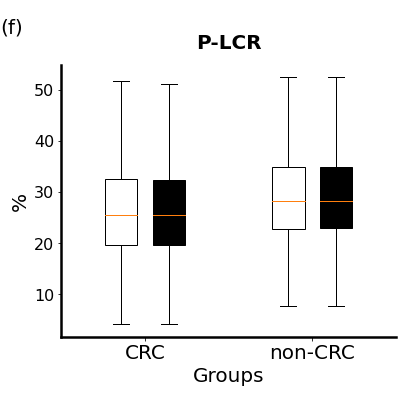

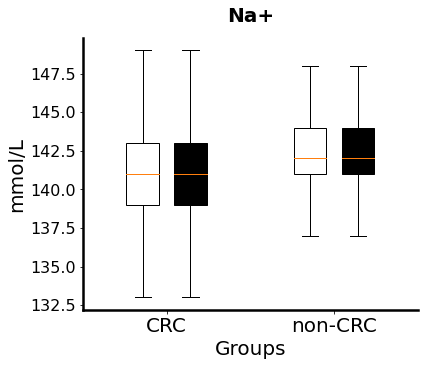

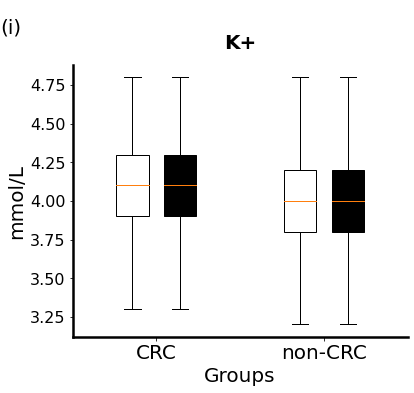

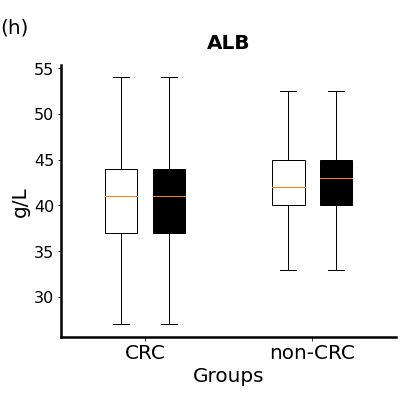

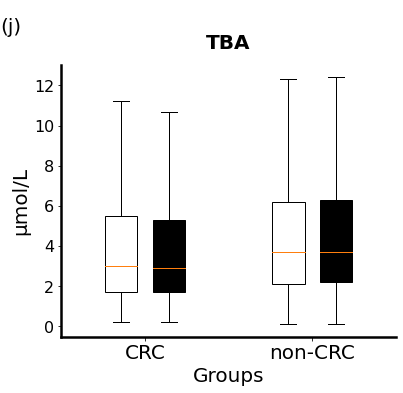

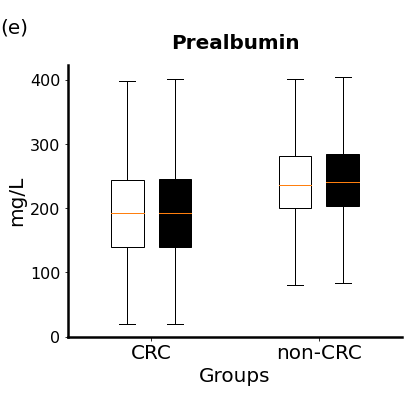

In [133]:
for i in all_data.columns[:-4]:

    s=unit[unit["Eng name"]==i]
    s.reset_index(inplace=True)
    proper_unit= s["unit"].loc[len(s)-1]

    box_1, box_2 = all_data[all_data["癌"]==1][i], confident_data[confident_data["癌"]==1][i]
    box_3, box_4 = all_data[all_data["癌"]==0][i], confident_data[confident_data["癌"]==0][i]

    f, ax= plt.subplots(figsize = (6, 5))
    plt.title(i,fontsize=20,pad=16,fontweight="bold")#标题，并设定字号大小
    labels = 'CRC','nonCRC'#图例
    color_list = [(1,1,1), (0,0,0),(1,1,1), (0,0,0)]
    bp=plt.boxplot([box_1,box_2,box_3,box_4],patch_artist=True, positions=(1,1.4,2.4,2.8), vert=True,showmeans=False,sym="")

    for patch, color in zip(bp['boxes'], color_list):
        patch.set_facecolor(color)
    
        labels = ["All data","Confident data"]
        if i == "Age":
            plt.legend(bp['boxes'], labels, loc='best')  # 绘制表示框，右下角绘制
        ax.set_xlabel('Groups',fontsize=20)
        ax.set_ylabel(proper_unit,fontsize=20)
        ax.tick_params(labelsize=16)

    x_position = [1.2,2.6]
    x_position_fmt = ["CRC","non-CRC"]
    plt.xticks([i  for i in x_position], x_position_fmt,fontsize=20)

    for spine in ax.spines.values():
        spine.set_linewidth(2.5)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    try:
        ax.annotate(anno_list_1[nonbin_useful_item.index(i)], xy=(1, 1), xytext=(0, 1),xycoords="figure fraction",fontsize=20)
    except: 
        pass;
    
    #try:
        #plt.savefig(r"D:\HKUST\Program\结肠癌分类器\终稿\论文图片精修\图片修改v2\Fig12" +"/" +anno_list_1[nonbin_useful_item.index(i)]+".png",dpi=800,bbox_inches='tight',pad_inches=0.2)
    #except:
        #pass;
    
    try:
        plt.savefig(r"D:\HKUST\Program\结肠癌分类器\终稿\论文图片精修\图片修改v2\Fig12" +"/" + i+".png",dpi=800,bbox_inches='tight',pad_inches=0.2)
    except:
        plt.savefig(r"D:\HKUST\Program\结肠癌分类器\终稿\论文图片精修\图片修改v2\Fig12" +"/" + "The ratio between A and G"+".png",dpi=800,bbox_inches='tight',pad_inches=0.2)

In [80]:
stats.ttest_ind(box_1,box_3 , equal_var= False)

Ttest_indResult(statistic=-0.5047025084252463, pvalue=0.6137952768307344)

In [131]:
unit


,CN name,Eng name,unit
0,血_白细胞计数,WBC,10^9/L
1,血_淋巴细胞计数,Lym,10^9/L
2,血_单核细胞计数,Mon,10^9/L
3,血_中性粒细胞计数,Leu,10^9/L
4,血_嗜酸粒细胞计数,Eos,10^9/L
...,...,...,...
66,尿_胆红素,Urine bilirubin,μmol/L
67,尿_红细胞血红蛋白,Urine Hb,/μL
68,年龄,Age,year
69,性别,Gender,无


In [479]:
    i="PCT"
    s=unit[unit["Eng name"]==i]
    s.reset_index(inplace=True)
    proper_unit= s["unit"].loc[len(s)-1]

    box_1, box_2 = all_data[all_data["癌"]==1][i], confident_data[confident_data["癌"]==1][i]
    box_3, box_4 = all_data[all_data["癌"]==0][i], confident_data[confident_data["癌"]==0][i]

    f, ax= plt.subplots(figsize = (8, 6))
    plt.title(i,fontsize=20)#标题，并设定字号大小
    labels = 'CRC','nonCRC'#图例
    color_list = [(1,1,1), (0,0,0),(1,1,1), (0,0,0)]
    bp=plt.boxplot([box_1,box_2,box_3,box_4],patch_artist=True, positions=(1,1.4,3,3.4), vert=True,showmeans=False,sym="")

    for patch, color in zip(bp['boxes'], color_list):
        patch.set_facecolor(color)
    
        labels = ["All data","Confident data"]
        plt.legend(bp['boxes'], labels, loc='best')  # 绘制表示框，右下角绘制
        ax.set_xlabel('Groups')
        ax.set_ylabel(proper_unit)

    x_position = [1,3]
    x_position_fmt = ["CRC","non-CRC"]
    plt.xticks([i + 0.4 / 2 for i in x_position], x_position_fmt)

KeyError: 'PCT'

In [105]:
all_data

,Age,WBC,Mon%,Eos%,RBC,RDW,P-LCR,Na+,K+,ALB,TBA,Prealbumin,FIT positive,FIT's data is missing',Gender,癌
3834,53,3.79,7.9,0.8,4.21,12.6,54.8,140.0,3.8,40.0,3.9,213.0,0,0,0.63176,0
26271,37,9.94,5.5,0.3,4.55,12.2,23.7,141.0,4.2,42.0,1.6,223.0,0,1,0.00000,0
16443,70,5.07,9.7,4.6,3.48,17.6,12.8,141.0,4.2,40.0,3.0,162.0,1,0,0.00000,1
9427,58,3.79,4.7,0.5,4.78,12.2,26.3,142.0,4.2,48.0,2.4,164.0,0,1,0.00000,0
6316,66,4.43,5.6,2.3,4.34,13.0,21.4,141.0,3.8,45.0,1.2,272.0,0,1,0.00000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15660,31,7.06,4.7,1.1,5.35,13.0,33.7,139.0,4.4,47.0,6.9,337.0,0,1,0.63176,0
17907,56,4.79,8.0,2.6,3.90,14.3,16.7,143.0,4.1,46.0,9.5,234.0,0,0,0.00000,1
10128,71,4.82,4.8,1.0,4.13,12.8,26.0,145.0,3.7,38.0,12.1,172.0,0,0,0.00000,0
15533,80,6.15,7.0,1.9,4.44,13.2,16.4,143.0,4.6,45.0,4.6,226.0,1,0,1.00000,1


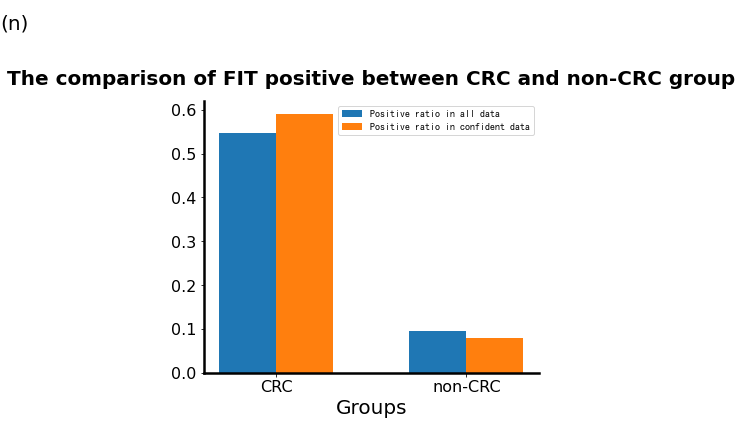

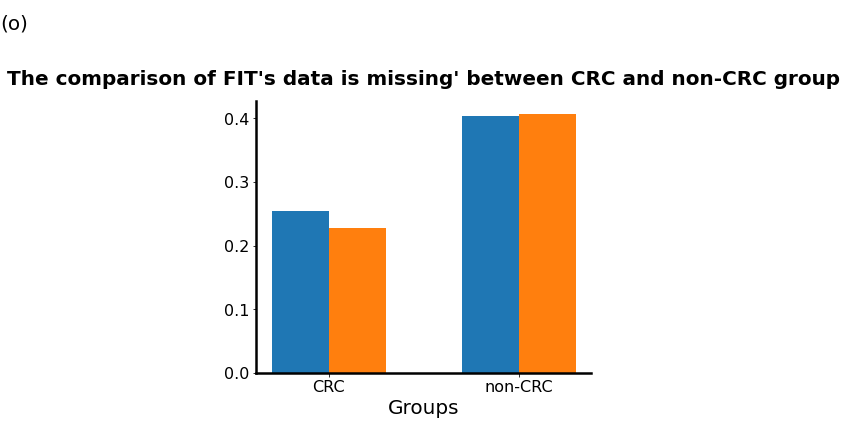

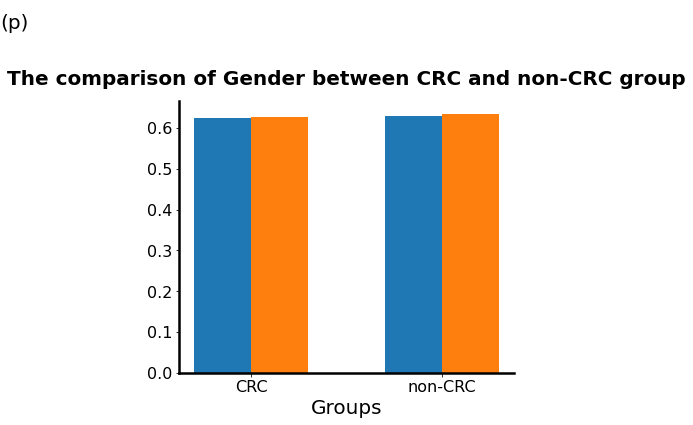

In [137]:
for i in all_data.columns[-4:-1]:
    
    box_1, box_2 = all_data[all_data["癌"]==1][i], confident_data[confident_data["癌"]==1][i]
    box_3, box_4 = all_data[all_data["癌"]==0][i], confident_data[confident_data["癌"]==0][i]
    
    ratio_pos_1=box_1.sum()/box_1.count()
    #ratio_neg_1=1-box_1.sum()/box_1.count()
    ratio_pos_2=box_2.sum()/box_2.count()
    #ratio_neg_2=1-box_2.sum()/box_2.count()
    ratio_pos_3=box_3.sum()/box_3.count()
    ratio_pos_4=box_4.sum()/box_4.count()

    fig, ax = plt.subplots(figsize=(6,5))
    
    plt.title('The comparison of '+i+" between CRC and non-CRC group",fontsize=20, pad=16, fontweight="bold")#标题，并设定字号大小
    ax.bar(x=[0.2,0.7],height=[ratio_pos_1,ratio_pos_3],width=0.15,label="Positive ratio in all data")
    ax.bar(x=[0.35,0.85],height=[ratio_pos_2,ratio_pos_4],width=0.15,label="Positive ratio in confident data")
    #plt.legend(prop={'family':'SimHei','size':8},bbox_to_anchor=(0.42, 1))
    if i=="FIT positive":
        plt.legend(prop={'family':'SimHei','size':10},loc=1)
        
    ax.set_xlabel('Groups',fontsize=20)
    ax.set_xticks([0.275,0.775])
    ax.set_xticklabels(["CRC","non-CRC"],fontsize=20)
    ax.tick_params(labelsize=16)
    
    
    for spine in ax.spines.values():
        spine.set_linewidth(2.5)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    try:
        ax.annotate(anno_list_2[bin_useful_item.index(i)], xy=(1, 1), xytext=(0, 1.1),xycoords="figure fraction",fontsize=20)
    except: 
        pass;
    
    try:
        plt.savefig(r"D:\HKUST\Program\结肠癌分类器\终稿\论文图片精修\图片修改v2\Fig12" +"/" +anno_list_2[bin_useful_item.index(i)]+".png",dpi=800,bbox_inches='tight',pad_inches=0.2)
    except:
        pass;
    

    plt.savefig(r"D:\HKUST\Program\结肠癌分类器\终稿\论文图片精修\图片修改v2\Fig12" +"/" + i+".png",dpi=800,bbox_inches='tight',pad_inches=0.2)


In [96]:
ssss=pd.read_excel(r"D:\HKUST\Program\结肠癌分类器\终稿\combined_data_mean.xlsx")

In [99]:
df[df["癌"]==1]

,Age,WBC,Lym,Mon,Ne,Eos,Baso,Lym%,Mon%,Eos%,Baso%,Ne%,RBC,Hb,HCT,MCV,MCH,MCHC,RDW,PLT,MPV,PCT,PDW,P-LCR,Urea,Na+,K+,Cl-,Glu,Creatinine,CO₂CP,Uric Acid,CA19-9,TBIL,DBIL,TP,ALB,Globulin,A/G,ALT,AST,ALP,TBA,γ-GT,Prealbumin,LDH,IBIL,CEA,FIT positive,FIT's data is missing',Fecal transferrin positive,Fecal transferrin's data is missing',Gender,BMI,癌
13,81,6.29,2.00,0.48,3.57,0.24,0.00,31.8,7.6,3.8,0.0,56.8,4.39,123.0,37.0,84.3,28.0,332.0,14.1,380.0,9.8,0.37,11.6,23.1,8.9,147.0,5.100000,106.0,6.2,80.0,26.0,0.14,6.100000,15.6,6.4,55.0,29.0,26.0,1.12,15.0,20.0,51.0,10.6,63.0,116.0,171.0,9.2,1.57,1,0,1,0,0.0,27.548209,1
22,56,18.04,0.71,0.96,16.26,0.08,0.03,4.0,5.4,0.4,0.1,90.1,4.56,139.0,41.1,90.0,30.4,338.0,14.3,82.0,10.3,0.09,16.4,29.0,4.0,144.0,3.900000,105.0,5.6,46.0,26.0,0.34,6.760000,7.2,2.8,65.0,37.0,28.0,1.32,30.0,45.0,164.0,4.9,121.0,158.0,223.0,4.4,2.02,0,0,0,0,0.0,23.238151,1
30,67,6.75,1.43,0.57,4.57,0.10,0.08,21.1,8.6,1.5,1.2,67.6,5.22,158.0,46.9,89.9,30.3,337.0,13.5,245.0,9.0,0.22,16.2,21.0,8.3,144.0,3.600000,106.0,6.3,79.0,27.0,0.27,7.320000,13.5,4.0,65.0,38.0,27.0,1.41,25.0,22.0,81.0,3.0,59.0,206.0,154.0,9.5,4.36,0,1,0,1,1.0,28.919237,1
46,59,9.60,1.20,0.69,7.53,0.16,0.02,12.5,7.2,1.7,0.2,78.4,4.07,124.0,36.7,90.1,30.5,339.0,14.1,330.0,8.7,0.29,16.2,18.9,2.9,142.0,4.062808,100.0,6.0,36.0,27.0,0.15,22.504914,35.4,23.6,64.0,27.0,37.0,0.73,41.0,46.0,335.0,29.6,412.0,31.0,1042.0,11.8,55.65,0,0,0,0,1.0,18.598616,1
53,51,4.00,1.71,0.34,1.92,0.03,0.00,42.8,8.5,0.8,0.0,47.9,4.23,144.0,41.4,97.9,34.0,348.0,16.0,110.0,10.1,0.11,12.1,26.1,4.6,140.0,5.100000,104.0,5.2,75.0,27.0,0.31,4.640000,13.6,4.5,79.0,47.0,32.0,1.47,59.0,46.0,59.0,6.4,38.0,255.0,191.0,9.1,1.26,0,0,1,0,1.0,26.961422,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27899,69,7.71,1.20,0.63,4.90,0.94,0.04,15.6,8.2,12.2,0.5,63.5,4.91,136.0,42.6,86.8,27.7,319.0,15.3,281.0,10.4,0.29,11.2,26.8,5.0,139.0,4.000000,101.0,5.8,74.0,26.0,0.11,9.490000,10.7,4.9,68.0,39.0,29.0,1.34,28.0,36.0,105.0,10.2,28.0,162.0,200.0,5.8,5.57,1,0,1,0,1.0,22.491349,1
27901,73,9.90,1.03,0.62,7.83,0.39,0.03,10.4,6.3,3.9,0.3,79.1,3.35,105.0,31.3,93.4,31.3,335.0,12.5,179.0,11.2,0.20,13.1,34.6,3.6,141.0,4.200000,107.0,5.4,125.0,23.0,0.22,5.330000,8.7,4.2,63.0,38.0,25.0,1.52,20.0,26.0,77.0,2.3,29.0,119.0,213.0,4.5,2.27,0,1,0,1,1.0,27.343750,1
27904,67,3.45,0.58,0.44,2.40,0.02,0.01,16.8,12.8,0.6,0.3,69.5,3.23,117.0,34.6,107.1,36.2,338.0,14.6,127.0,9.3,0.12,9.2,18.8,4.5,145.0,3.700000,107.0,5.1,63.0,26.0,0.41,25.030000,12.0,2.7,76.0,48.0,28.0,1.71,10.0,17.0,85.0,1.1,18.0,297.0,217.0,9.3,4.90,1,0,0,1,0.0,18.730489,1
27905,77,9.31,1.56,0.80,6.91,0.01,0.03,16.8,8.6,0.1,0.3,74.2,3.76,133.0,36.9,98.1,35.4,360.0,13.9,205.0,9.0,0.19,9.0,17.4,3.4,133.0,3.100000,92.0,9.6,48.0,26.0,0.11,20.690000,15.6,3.5,63.0,29.0,34.0,0.85,14.0,24.0,198.0,9.3,96.0,50.0,229.0,12.1,38.79,0,0,0,0,0.0,35.202140,1


In [127]:
simplified_merged.describe()

,Age,WBC,Mon%,Eos%,RBC,RDW,MPV,P-LCR,Na+,K+,TP,ALB,TBA,TBA,Prealbumin,FIT positive,FIT's data is missing',Fecal transferrin positive,Fecal transferrin's data is missing',Gender,癌
count,27911.000000,27911.000000,27911.000000,27911.000000,27911.000000,27911.000000,27911.000000,27911.000000,27911.000000,27911.000000,27911.000000,27911.000000,27911.000000,27911.000000,27911.000000,27911.000000,27911.000000,27911.000000,27911.000000,27911.000000,27911.000000
mean,57.106374,6.406604,7.295540,2.394024,4.365796,13.891526,10.315272,28.304356,141.783081,4.062700,69.012262,41.782545,1.519062,5.540764,225.418489,0.264770,0.331160,0.160689,0.479560,0.631882,0.360611
std,12.732917,3.290131,2.615873,2.280198,0.595358,2.652130,1.319886,9.505405,2.959390,0.371942,6.633423,5.316417,0.275277,10.198591,71.187597,0.441219,0.470639,0.367251,0.499591,0.457085,0.480186
min,8.000000,0.090000,0.000000,0.000000,0.100000,10.600000,6.100000,4.100000,121.000000,2.500000,36.000000,10.000000,0.150000,0.100000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,49.000000,4.880000,5.600000,1.000000,3.990000,12.400000,9.400000,21.400000,140.000000,3.800000,65.000000,39.000000,1.340000,2.000000,177.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,58.000000,6.010000,6.900000,1.800000,4.380000,13.000000,10.200000,27.600000,142.000000,4.062808,69.000000,42.000000,1.500000,3.500000,225.498810,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,66.000000,7.370000,8.500000,3.100000,4.770000,14.200000,11.100000,33.900000,144.000000,4.300000,73.000000,45.000000,1.680000,6.000000,272.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
max,100.000000,399.410000,70.000000,60.100000,6.980000,45.200000,17.900000,75.700000,154.000000,6.100000,108.000000,69.900000,3.940000,449.800000,583.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
